# Aim & Methods
The present notebook is an attempt at anlysing the prices of West Texas Intermediate (WTI) crude oil and their fluctuation across time,  and forecasting the price through various regression techniques.
### Python Packages used
 1. fredapi 
 1. pandas
 1. statsmodels
 1. darts
 1. pmdarima
 
### Methods used 
For forecasting, we'll use different methods. From pmdarima we'll use the auto_arima functionality that automatically determines the best arima order, and from the darts package, we'll use exponential smoothing, arima, prophet (from the facebook team), and neural networks. We will then combine them to get a more robust ensemble prediction.

### Downloading the data
We get the data from the Federal Reserve Economic Data (FRED) database through the dedicated API provided by the Federal Reserve bank of St. Louis (see https://github.com/mortada/fredapi for more information). 

In [19]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [20]:
class CFG:
    def __init__(self):
        self.key_folder = 'api_key_file'
        self.img_dim1 = 20
        self.img_dim2 = 10
        
cfg = CFG() 
plt.rcParams.update({'figure.figsize': (cfg.img_dim1,cfg.img_dim2)})  

In [21]:
from fredapi import Fred
fred = Fred(api_key_file=cfg.key_folder)
df_WTI_list = fred.search('WTI')
df_WTI_list.T

series id,DCOILWTICO,MCOILWTICO,WCOILWTICO,ACOILWTICO,WTISPLC,POILWTIUSDM,POILWTIUSDQ,POILWTIUSDA,OILPRICE
id,DCOILWTICO,MCOILWTICO,WCOILWTICO,ACOILWTICO,WTISPLC,POILWTIUSDM,POILWTIUSDQ,POILWTIUSDA,OILPRICE
realtime_start,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00
realtime_end,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00,2023-01-26 00:00:00
title,Crude Oil Prices: West Texas Intermediate (WTI...,Crude Oil Prices: West Texas Intermediate (WTI...,Crude Oil Prices: West Texas Intermediate (WTI...,Crude Oil Prices: West Texas Intermediate (WTI...,Spot Crude Oil Price: West Texas Intermediate ...,Global price of WTI Crude,Global price of WTI Crude,Global price of WTI Crude,Spot Oil Price: West Texas Intermediate (DISCO...
observation_start,1986-01-02 00:00:00,1986-01-01 00:00:00,1986-01-03 00:00:00,1986-01-01 00:00:00,1946-01-01 00:00:00,1990-01-01 00:00:00,1990-01-01 00:00:00,1990-01-01 00:00:00,1946-01-01 00:00:00
observation_end,2023-01-23 00:00:00,2022-12-01 00:00:00,2023-01-20 00:00:00,2022-01-01 00:00:00,2022-12-01 00:00:00,2022-11-01 00:00:00,2022-07-01 00:00:00,2021-01-01 00:00:00,2013-07-01 00:00:00
frequency,Daily,Monthly,"Weekly, Ending Friday",Annual,Monthly,Monthly,Quarterly,Annual,Monthly
frequency_short,D,M,W,A,M,M,Q,A,M
units,Dollars per Barrel,Dollars per Barrel,Dollars per Barrel,Dollars per Barrel,Dollars per Barrel,U.S. Dollars per Barrel,U.S. Dollars per Barrel,U.S. Dollars per Barrel,Dollars per Barrel
units_short,$ per Barrel,$ per Barrel,$ per Barrel,$ per Barrel,$ per Barrel,U.S. $ per Barrel,U.S. $ per Barrel,U.S. $ per Barrel,$ per Barrel


In [22]:
df_WTI_list[df_WTI_list['frequency'] == 'Daily']

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
DCOILWTICO,DCOILWTICO,2023-01-26,2023-01-26,Crude Oil Prices: West Texas Intermediate (WTI...,1986-01-02,2023-01-23,Daily,D,Dollars per Barrel,$ per Barrel,Not Seasonally Adjusted,NSA,2023-01-25 12:16:01-06:00,79,"Definitions, Sources and Explanatory Notes (ht..."


Only the 'DCOILWTICO' has a daily sampling frequency, so we'll use this one. The price is given in dollars per barrel, and the time series extends all the way back from 1986 (January the second) to today (January 9th, 2023 at the time of writing).

In [23]:
DCOIL = df_WTI_list.loc['DCOILWTICO']['id']#[df_WTI_list['frequency']=='Daily'].id[0]
WTI_price_series = fred.get_series(DCOIL)

# Analysing the data

Let's first look at the data, to try and understand what its main features are, and what models would be best to forecast future values

#### Missing values
As seen from the cell below, some of the values are missing (about 3.4%). The majority of functions we'll be using to analyse the time series do not accept NaNs so let's take care of these missing values first. We could research other datasets to find them, but let's pretend they are not retrievable and use a forward fill function to take care of these.

In [24]:
WTI_price_series[WTI_price_series.isnull()]

1986-02-17   NaN
1986-03-28   NaN
1986-05-26   NaN
1986-07-04   NaN
1986-09-01   NaN
              ..
2022-09-05   NaN
2022-11-24   NaN
2022-12-26   NaN
2023-01-02   NaN
2023-01-16   NaN
Length: 331, dtype: float64

<AxesSubplot:xlabel='Time', ylabel='WTI crude oil, dollars per barrel'>

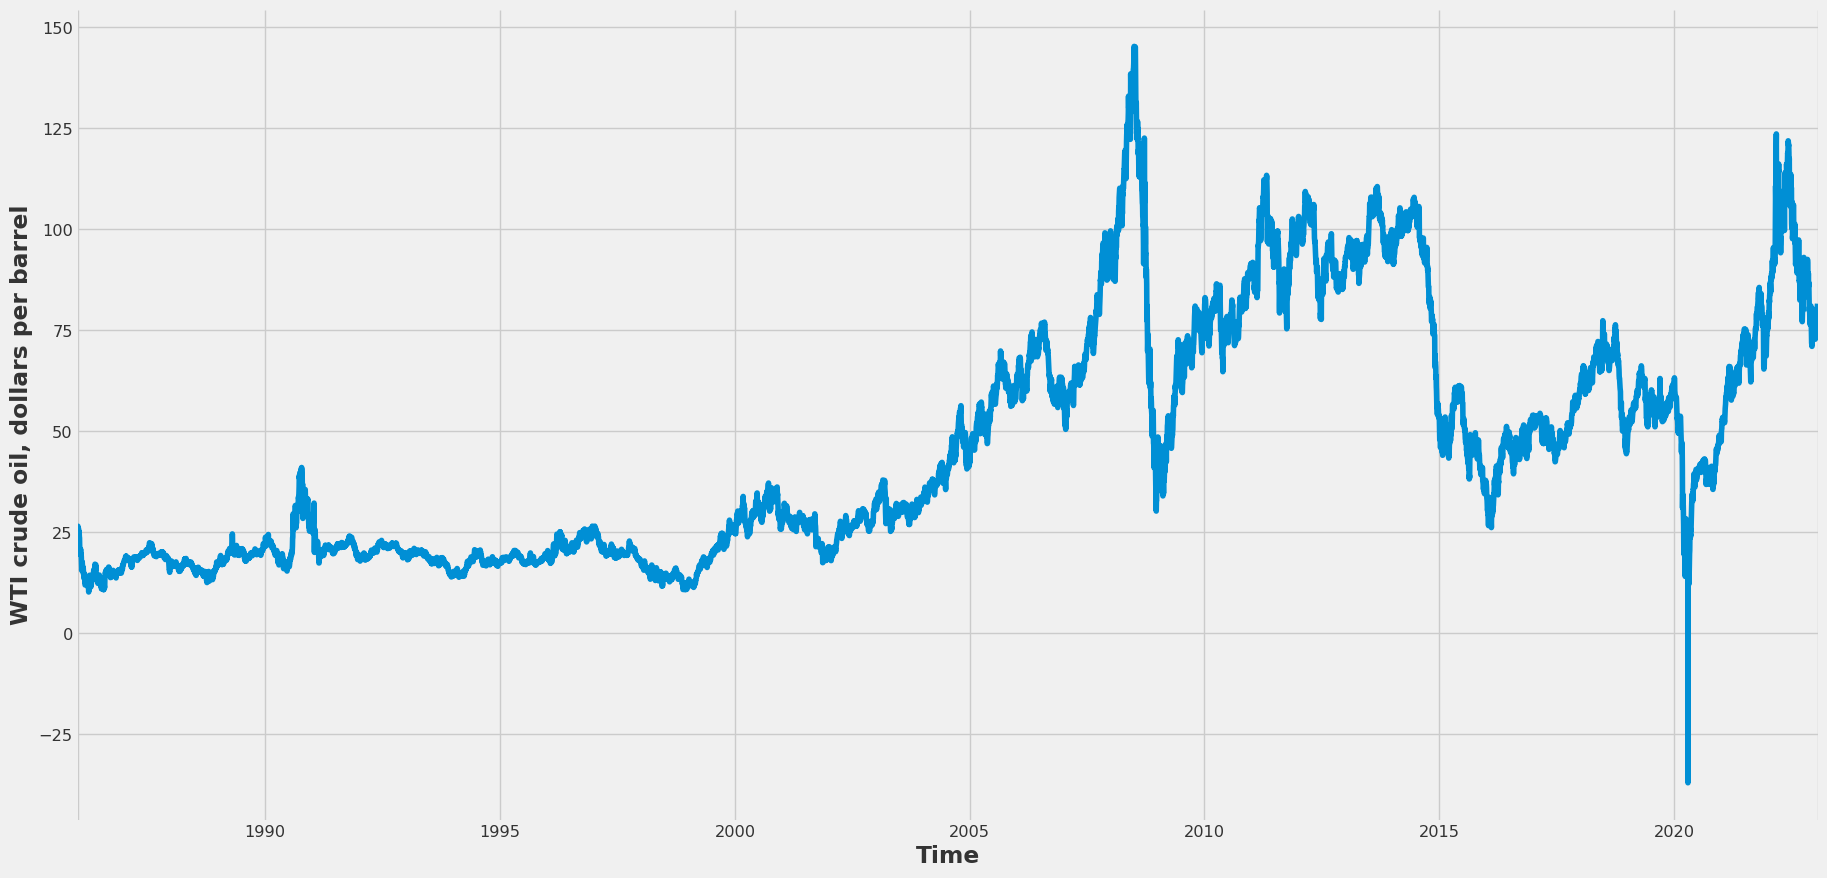

In [25]:
WTI_filled = WTI_price_series.fillna(method='ffill')
WTI_filled.plot(xlabel='Time', ylabel='WTI crude oil, dollars per barrel')

## A touch of fundamental analysis

We can see from the above graph the major events of the last three decades reflected in the prices of WTI crude oil. While it is not the exercise of this notebook to delve into politico-economic considerations, it is instructive to look at some of the most important events and how they reflected on the WTI prices.

#### Persian gulf war of 1990
The prices The spike around 1990 is a reflection of the uncertainty of global oil supply due to the persian gulf war. The maximal value during that period is of 41.07 $ on the 11th of october 1990, just a few months before operation Desert Storm, the second phase of the war. 

#### Subprimes crisis of 2008
Another huge spike appears around july 2008, although it is preceded by a longer phase of growth starting around 2002 which can be explained by the prosperous general economic conditions. The maximum happens on the 7th of July 2008 with a value of $ 145.31, followed by a steep decline, reaching a minimum on the 23rd of december 2008 at barely 30.28 dollars. 

#### Covid-19
We all remember the covid-19 pandemic, and so does the WTI crude oil dataset. Here for the first time, we even see a negative (!) price in it. The price per barrel dropped all the way down to -36.98 on the 4th of April 2020, following various lockdown decisions, which heavily reduced travel and thus ultimately the need for oil. Because the oil consumption sank so drastically, there started to be a shortage of storage for physical oil, so that futures contracts got massively shorted in order for their holders not to have to take delivery of the physical goods.

#### Current 
Because of the current situation in Ukraine which started beginning of 2022 (February 24th), a spike similar to the one of 1990 is observed although much more pronounced, and lasting for a longer time as well. It is a result of the various sanctions that have been put on Russia as a result of their invasion of ukrainian territory.

In [26]:
WTI_gulf_war = WTI_filled['1990-08-02':'1991-02-28']
max_value = WTI_gulf_war.max()
max_date = WTI_gulf_war.index[WTI_gulf_war == max_value]
print(f'During the gulf war, the prices hit a maximal value of {max_value} on the {str(max_date.date[0])}')

During the gulf war, the prices hit a maximal value of 41.07 on the 1990-10-11


In [27]:
WTI_subprimes = WTI_filled['2007-01-01':'2009-06-01']
max_value = WTI_subprimes.max()
max_date = WTI_subprimes.index[WTI_subprimes == max_value]
min_value = WTI_subprimes.min()
min_date = WTI_subprimes.index[WTI_subprimes == min_value]
print(f'Just before the subprime crisis, the prices rose to a maximal value of {max_value} on the {str(max_date.date[0])}')
print(f'They then fell to a value of {min_value}, on the {str(min_date.date[0])}')

Just before the subprime crisis, the prices rose to a maximal value of 145.31 on the 2008-07-03
They then fell to a value of 30.28, on the 2008-12-23


In [28]:
WTI_covid = WTI_filled['2020-03-01':'2021-06-01']
min_value = WTI_covid.min()
min_date = WTI_covid.index[WTI_covid==min_value]
print(f'The incredible value of {min_value}, was attained on the {str(min_date.date[0])}')

The incredible value of -36.98, was attained on the 2020-04-20


### Autocorrelation and partial autocorrelation
Next let's look at the correlation and partial autocorrelation of the time-series. These can give us important information as to whether or not it is a good idea to apply an autoregressive model.

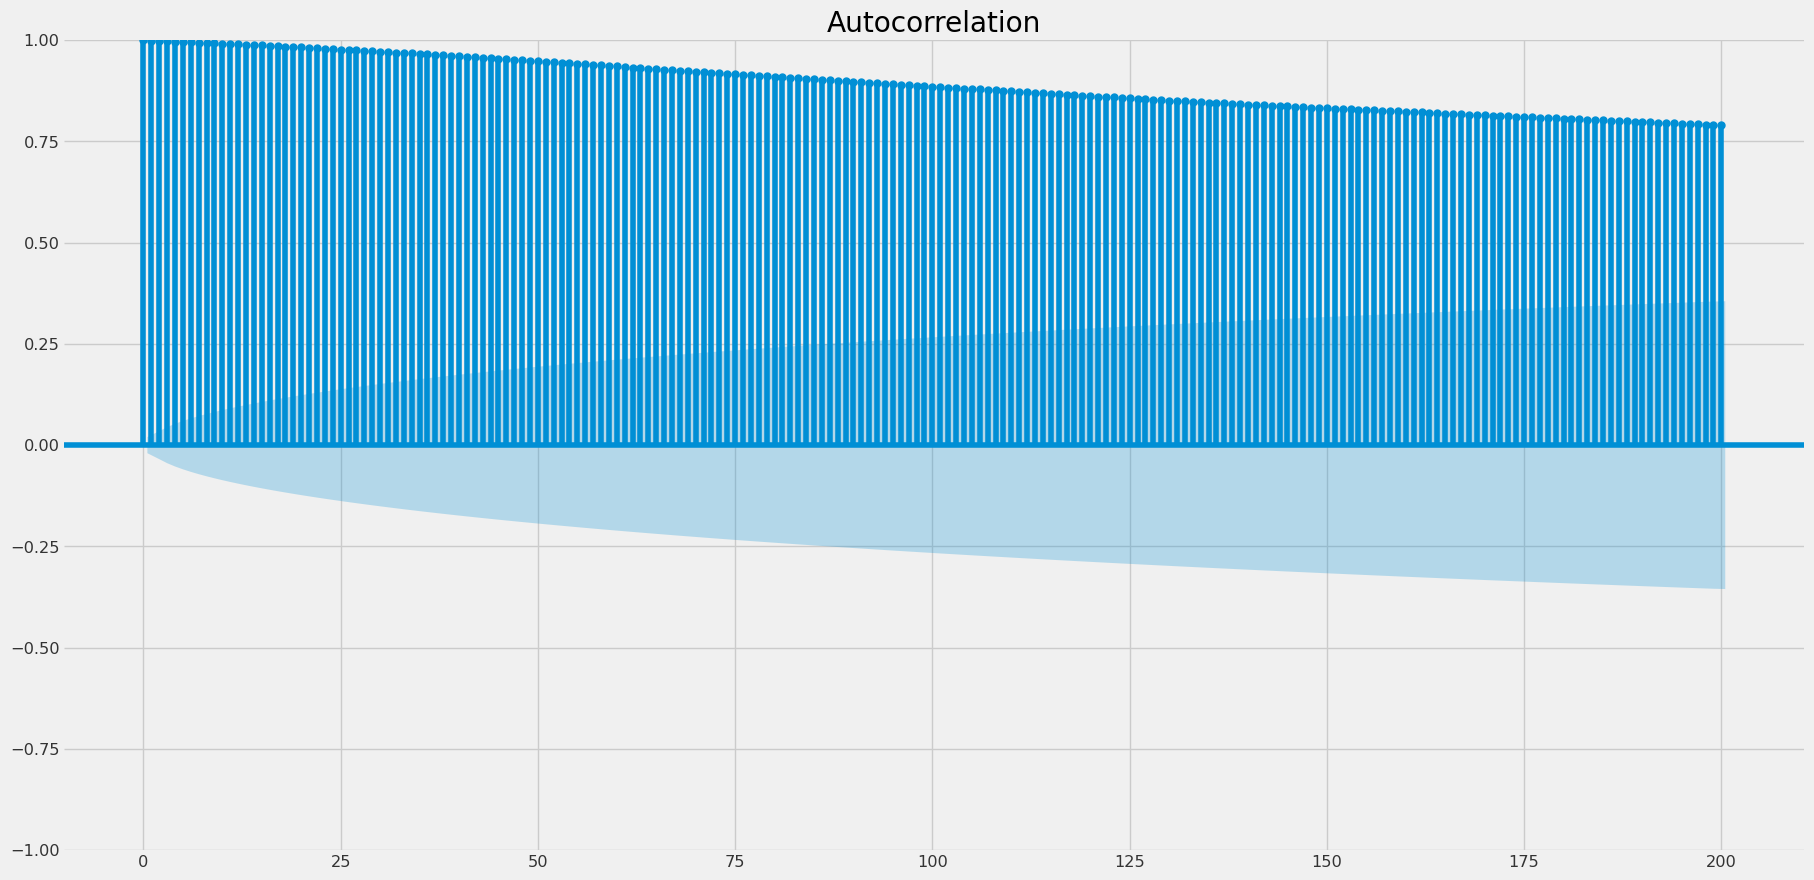

In [29]:
plot = plot_acf(WTI_filled, lags=200)

The autocorrelation decays roughly linelarly to zero, a behaviour expected for an AR time series with trend. The light blue bell shape around the x-axis is the 95% confidence interval, meaning anything that is above it is statistically significant. In this case, the autocorrelation's value is very much above that threshold.

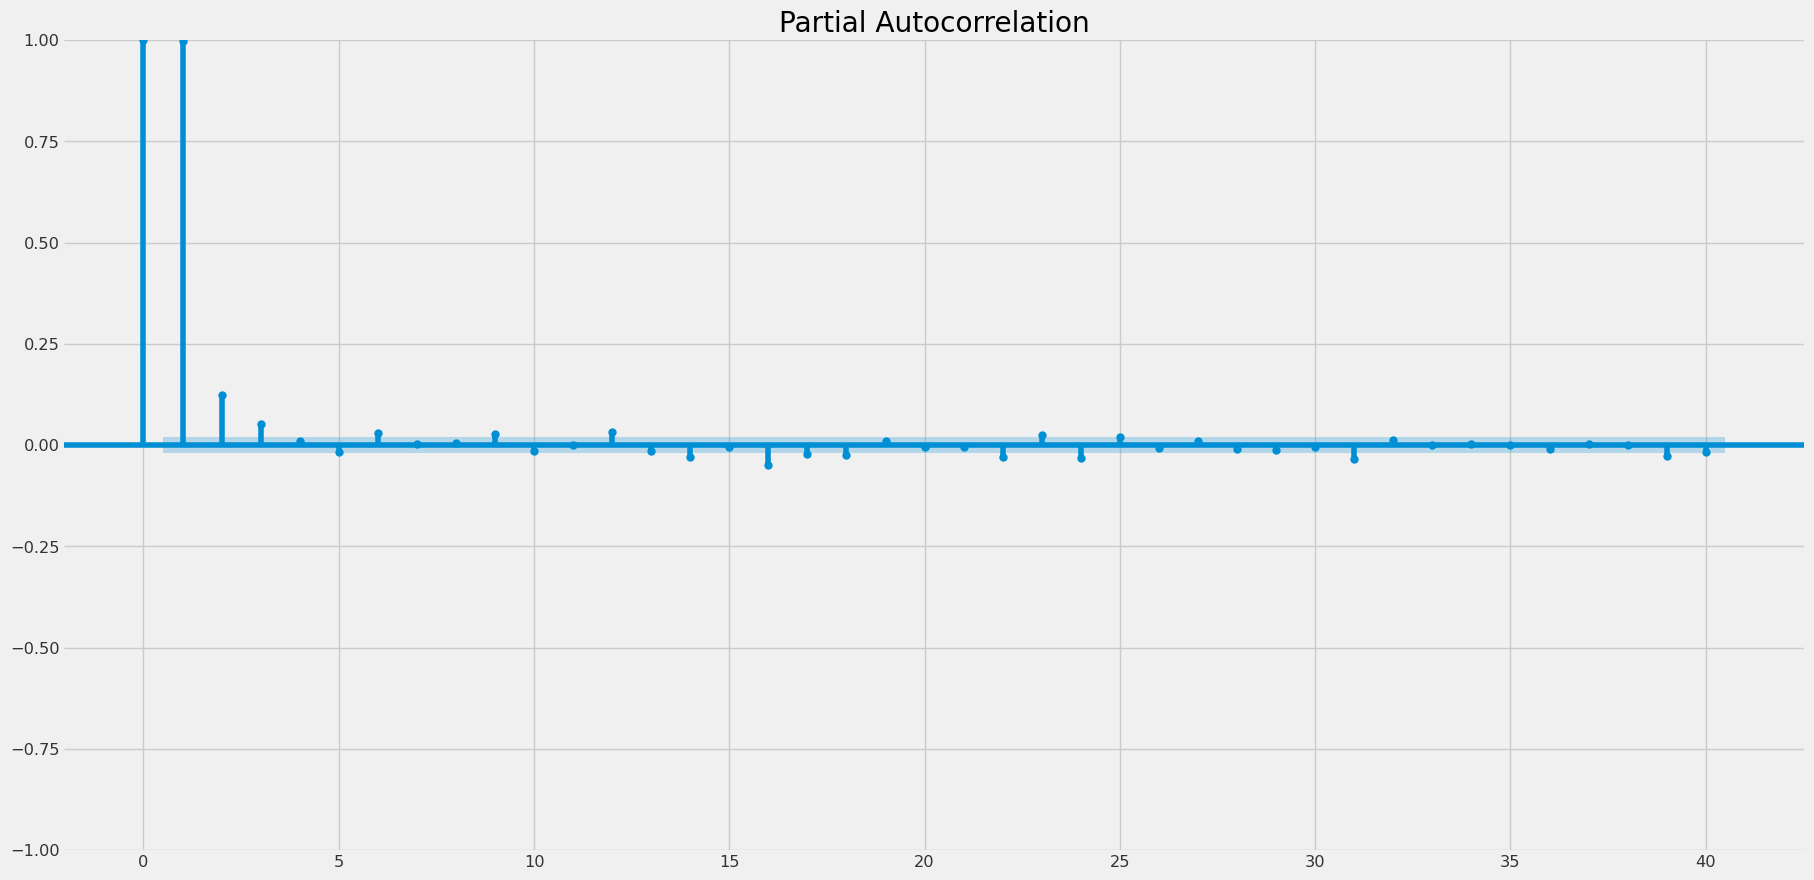

In [30]:
plot = plot_pacf(WTI_filled, method='ywm')

#### Conclusions from the ACF and PACF plots

The plots for the autocorrelation function and partial autocorrelation function are typical of an autoregressive (AR in what follows) series, i.e. a series of the form 
$$
X_t = \sum_{i=1}^p \varphi_i X_{t-i} + \epsilon_t
$$
where the $\varphi_i$ are coefficients in $\mathbb{R}$ and $\epsilon_t$ is a white noise component. As is obvious from their definition and the autocorrelation plot from above, those have strong time dependencies and we should take care of that before moving on. It is often the case for such time series, that differencing them once (differencing is the equivalent of differentiating but for functions defined on a discrete interval) takes care of the autocorrelation. That means that the differenced stock should not display a strong autocorrelation anymore. Let's see if that's true:

<AxesSubplot:>

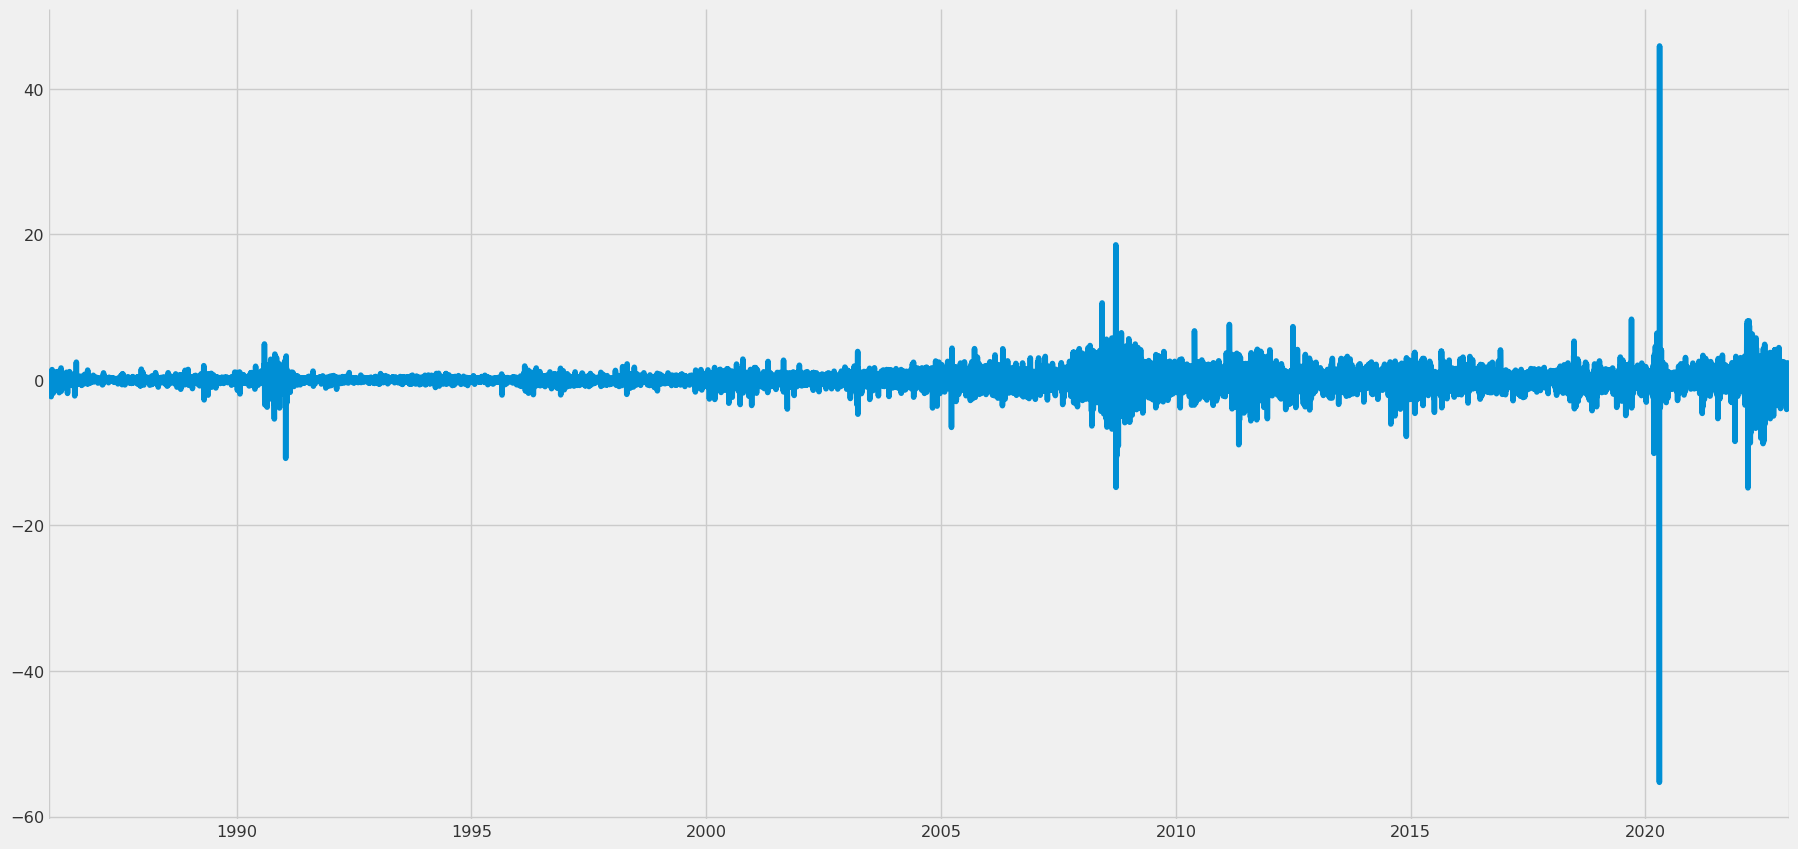

In [31]:
WTI_prices_diff = WTI_filled.diff().fillna(method='bfill')
WTI_prices_diff.plot()

The graph above displays a nice symmetry about the x-axis, showing how the market has a tendency to restore itself to its previous state after an extreme event; after a strong upward (downward) event, there is almost always a strong downward (upward) trend. This is obviously not strictly true, otherwise today's price would be the same as in 1986 (25$, if only!), but none the less an interesting observation to keep in mind.

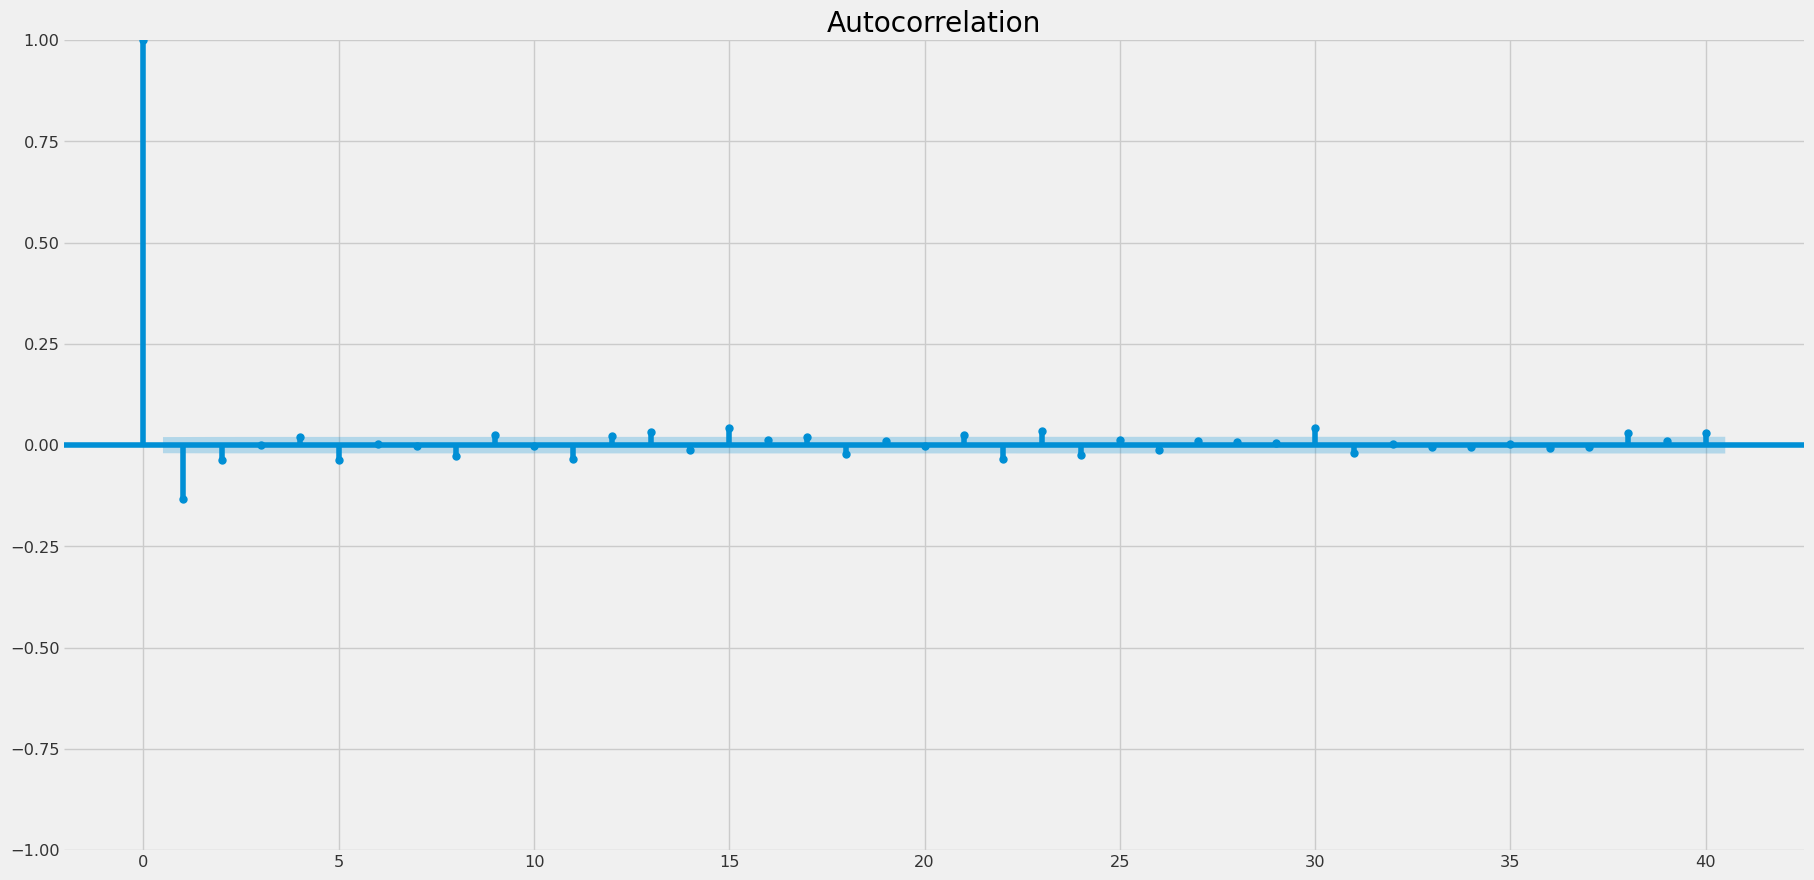

In [32]:
plot = plot_acf(WTI_prices_diff)

Now the autocorrelation function fluctuates around zero, indicating a lack of autocorrelation. This is typical of a first order AR process 

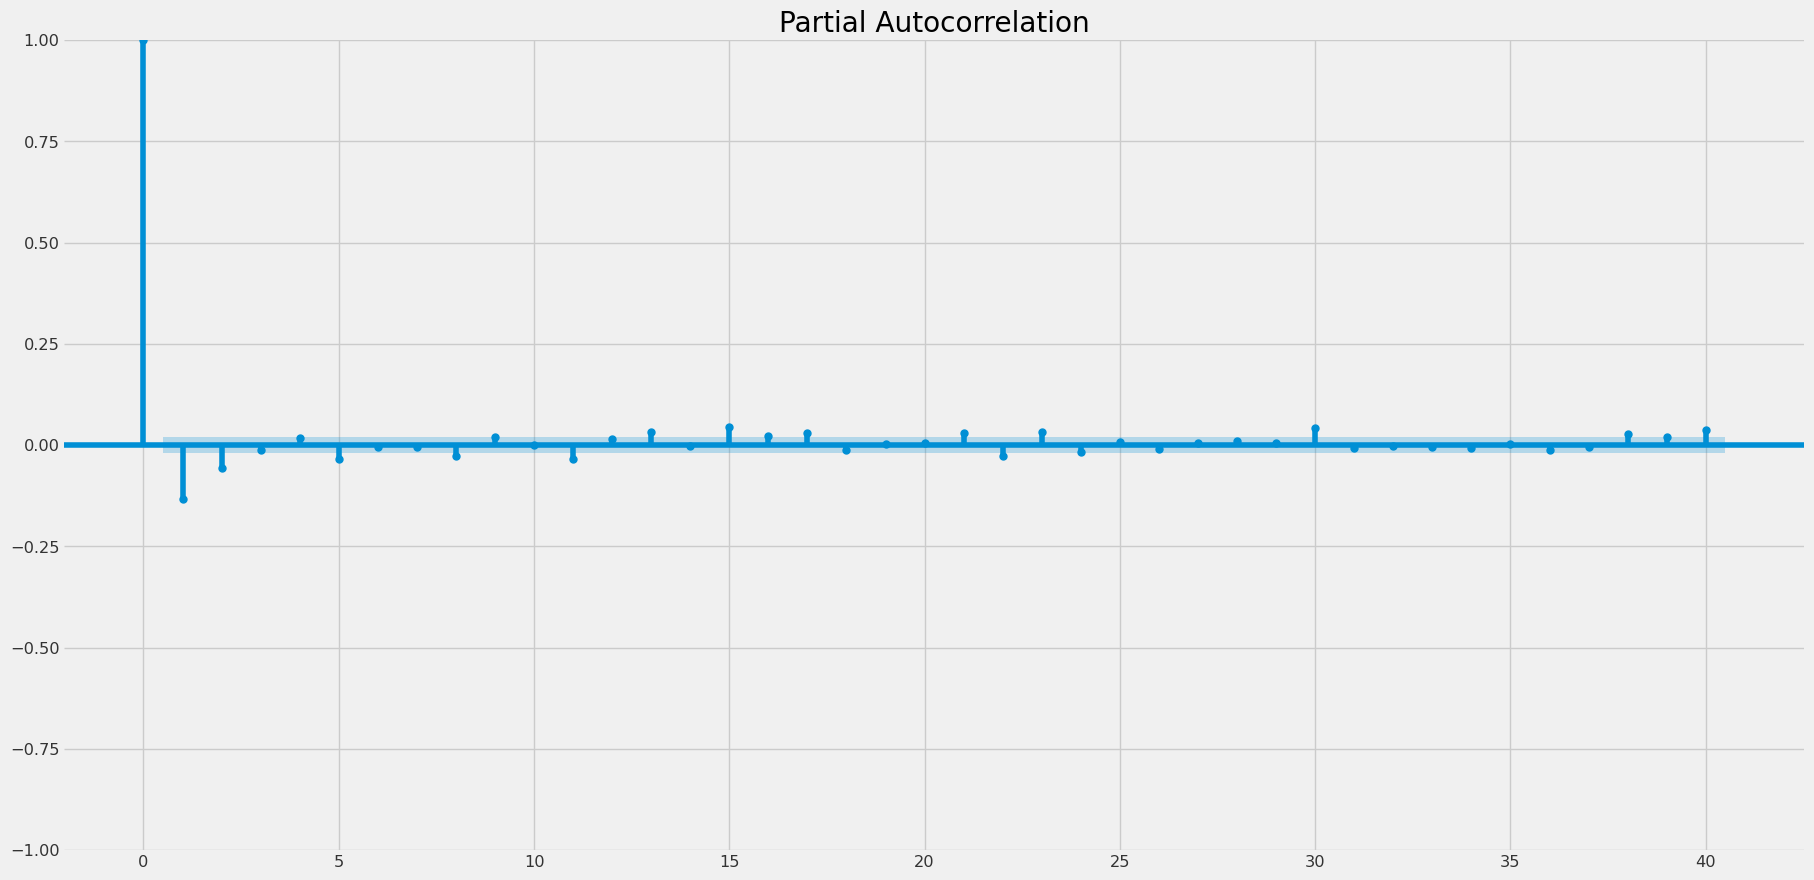

In [33]:
plot = plot_pacf(WTI_prices_diff, method='ywm') 

### Volatility
Before moving on to the seasonal decomposition, let's also look at the volatility of the time series. This can be a good indicator of extreme events.

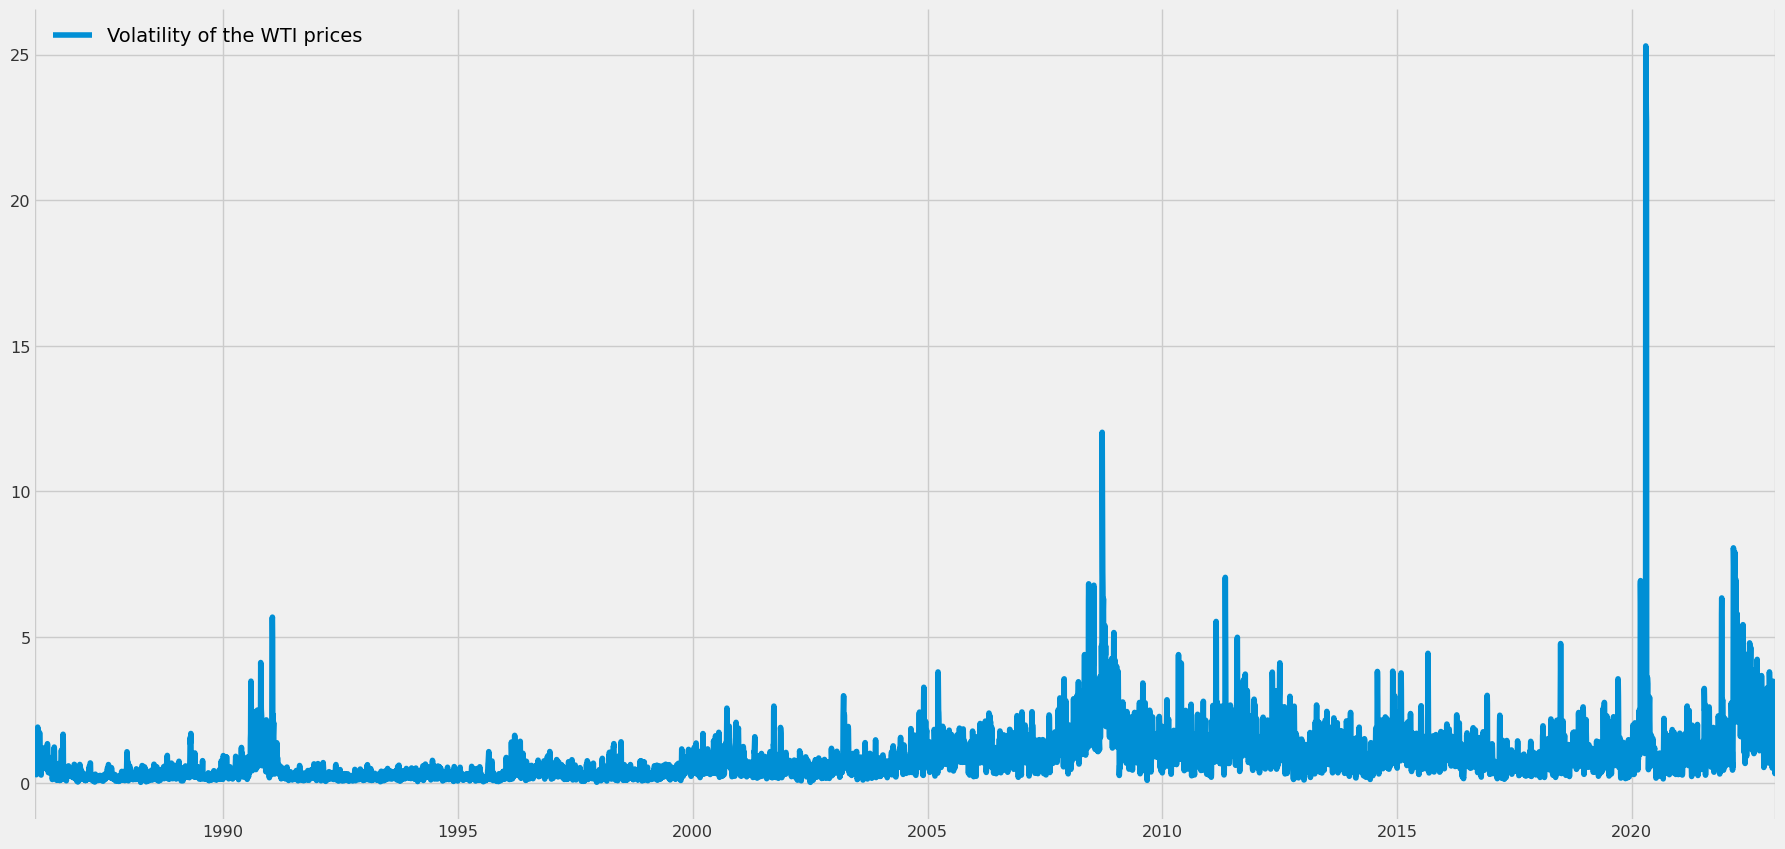

In [34]:
WTI_filled.rolling(5).std().plot(label='Volatility of the WTI prices')
plt.legend()

Now that we've established that the time series has a non-vanishing autocorrelation but the differenced time series does not, let's look at possible seasonal components or trend in the data with help of the seasonal_decompose function provided in the statsmodels package:

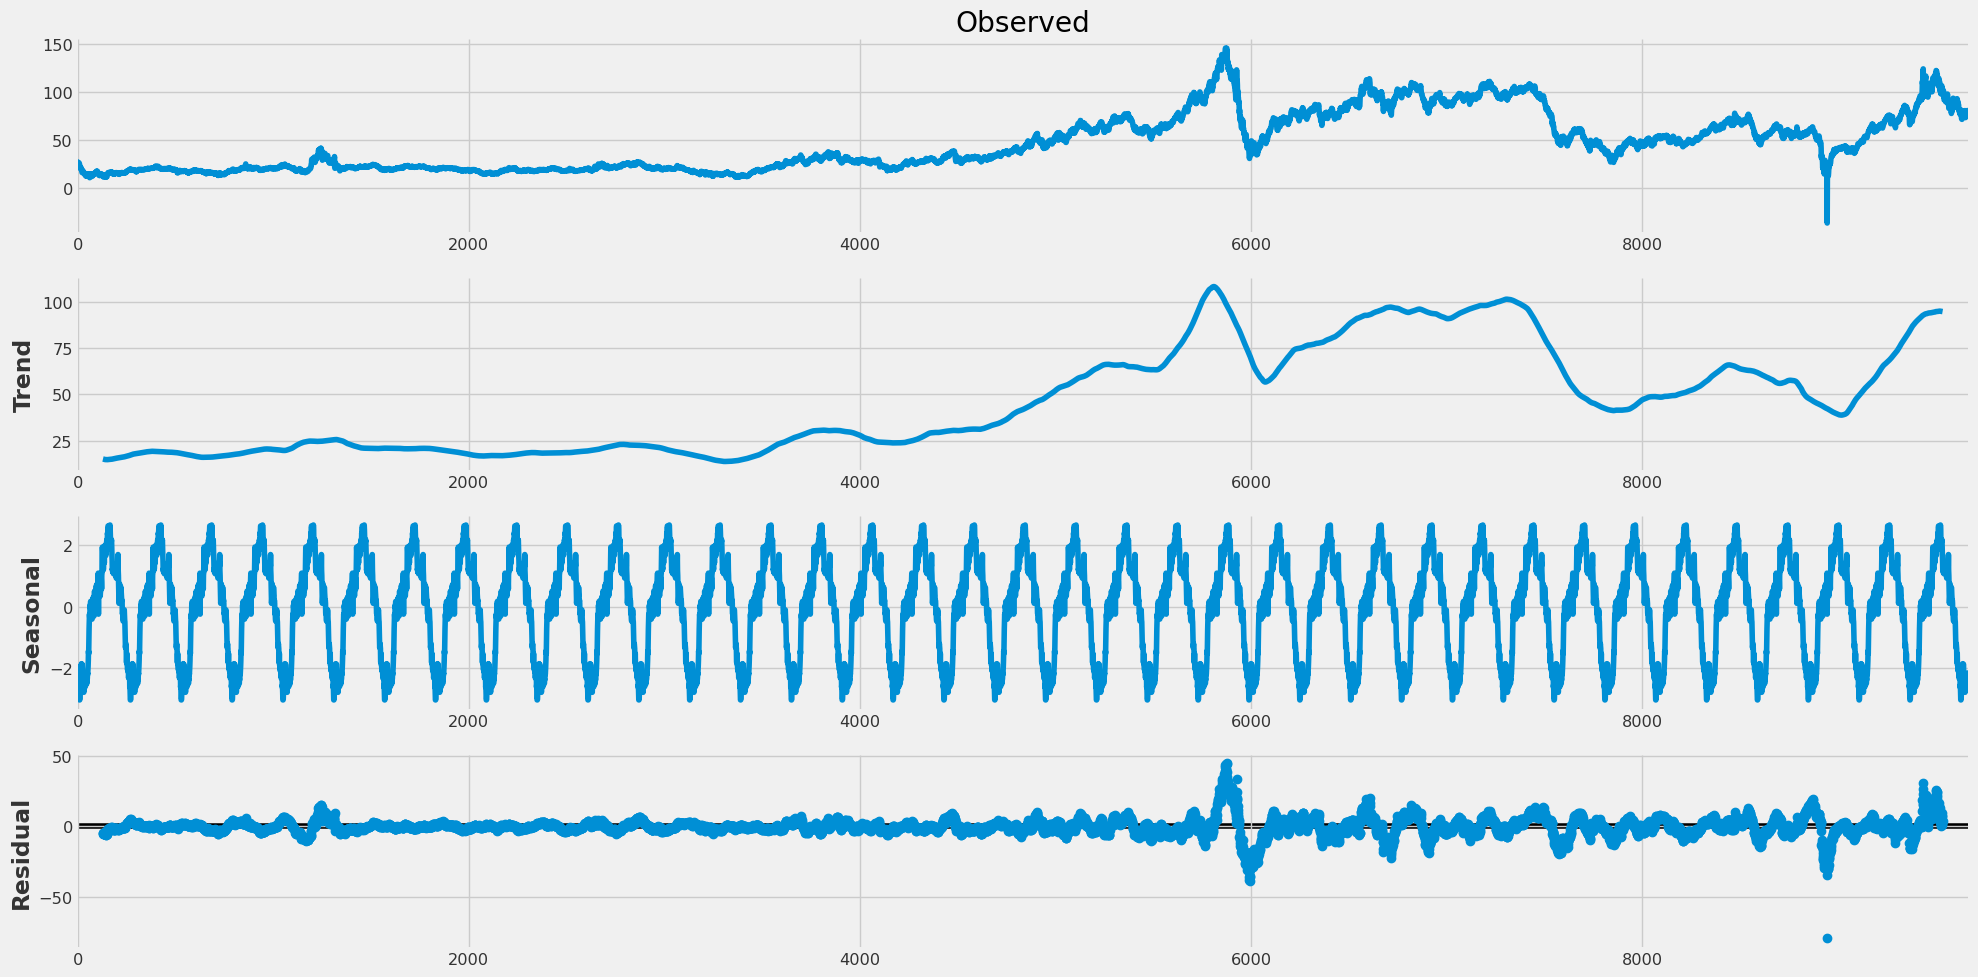

In [35]:
decomposition = seasonal_decompose(WTI_filled.values, period=260, model='additive')
figure = decomposition.plot()

The periodictiy of $260$ represents the average number of business days in a year. While the seasonal_decompose method provided by the statsmodels package is naive (for instance the trend part is a simple moving average), it nonetheless gives an idea of the importance of certain components. We see notably that the seaonal has a small amplitude of about $2$ and can therefore be neglected. The trend is not completely negligible, so let's test more formally with the to see if the stationarity hypothesis can be discarded or not. We'll use the augmented Dickey-Fuller test for that, which is also provided by the statsmodels package: 

In [36]:
adtest_original = adfuller(WTI_filled)
adtest_differenced = adfuller(WTI_prices_diff)
print(f'ADF-test p-value for the original time series: {adtest_original[1]}')
print(f'ADF-test p-value for the differenced time series: {adtest_differenced[1]}')

ADF-test p-value for the original time series: 0.19175911229477394
ADF-test p-value for the differenced time series: 7.514717877645652e-29


The tests show that the null-hypothesis of no unit-root can not be rejected in the case of the WTI time series, but is strongly rejected for the differenced time series.

Now that we have a better understanding of the type of series we are working with, we could go ahead and try different ARIMA models out, however the autoarima method from the darTS package automates the whole process so we'll just use that. Because of the two above tests, we'll set $d=1$, but we'll let the AutoARIMA functionaliy determine the best values of $p$ and $q$ for us.

We separate the data into a training and a test set.

In [37]:
sep_date = pd.to_datetime('20200101')
y_train = WTI_filled[:sep_date]
y_test = WTI_filled[sep_date:]

In [38]:
import pmdarima as pm

In [39]:
best_model = pm.auto_arima(y_train, start_p=1, start_q=1, max_p=10, max_q=10,
                             start_P=0, seasonal=False, trace=True, d=1,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27322.824, Time=2.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27342.688, Time=1.80 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27325.207, Time=2.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27324.008, Time=2.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27340.799, Time=1.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27319.965, Time=5.67 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27318.666, Time=2.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27318.518, Time=5.59 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=27314.604, Time=4.97 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=27303.571, Time=4.54 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=27304.889, Time=6.63 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=27304.433, Time=11.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=27306.140, Time=8.14 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=27306.390, Time=18.61 sec
 ARIMA(5,1,0)(0,0

In [40]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8870
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -13644.850
Date:                Thu, 26 Jan 2023   AIC                          27301.700
Time:                        14:57:53   BIC                          27344.242
Sample:                    01-02-1986   HQIC                         27316.186
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0472      0.004    -12.019      0.000      -0.055      -0.040
ar.L2         -0.0288      0.006     -4.906      0.000      -0.040      -0.017
ar.L3          0.0157      0.005      2.939      0.003       0.005       0.026
ar.L4          0.0240      0.005      4.745      0.000       0.014       0.034
ar.L5         -0.0383      0.005     -7.643      0.000      -0.048      -0.028
sigma2         1.2701      0.006    199.517      0.000       1.258       1.283
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            137302.80
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               7.79   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Verdict
AutoARIMA has spoken: we will choose a $(5,1,0)$ ARIMA model going forward. The fact that $p=5$ could be linked to the 5-days business week.

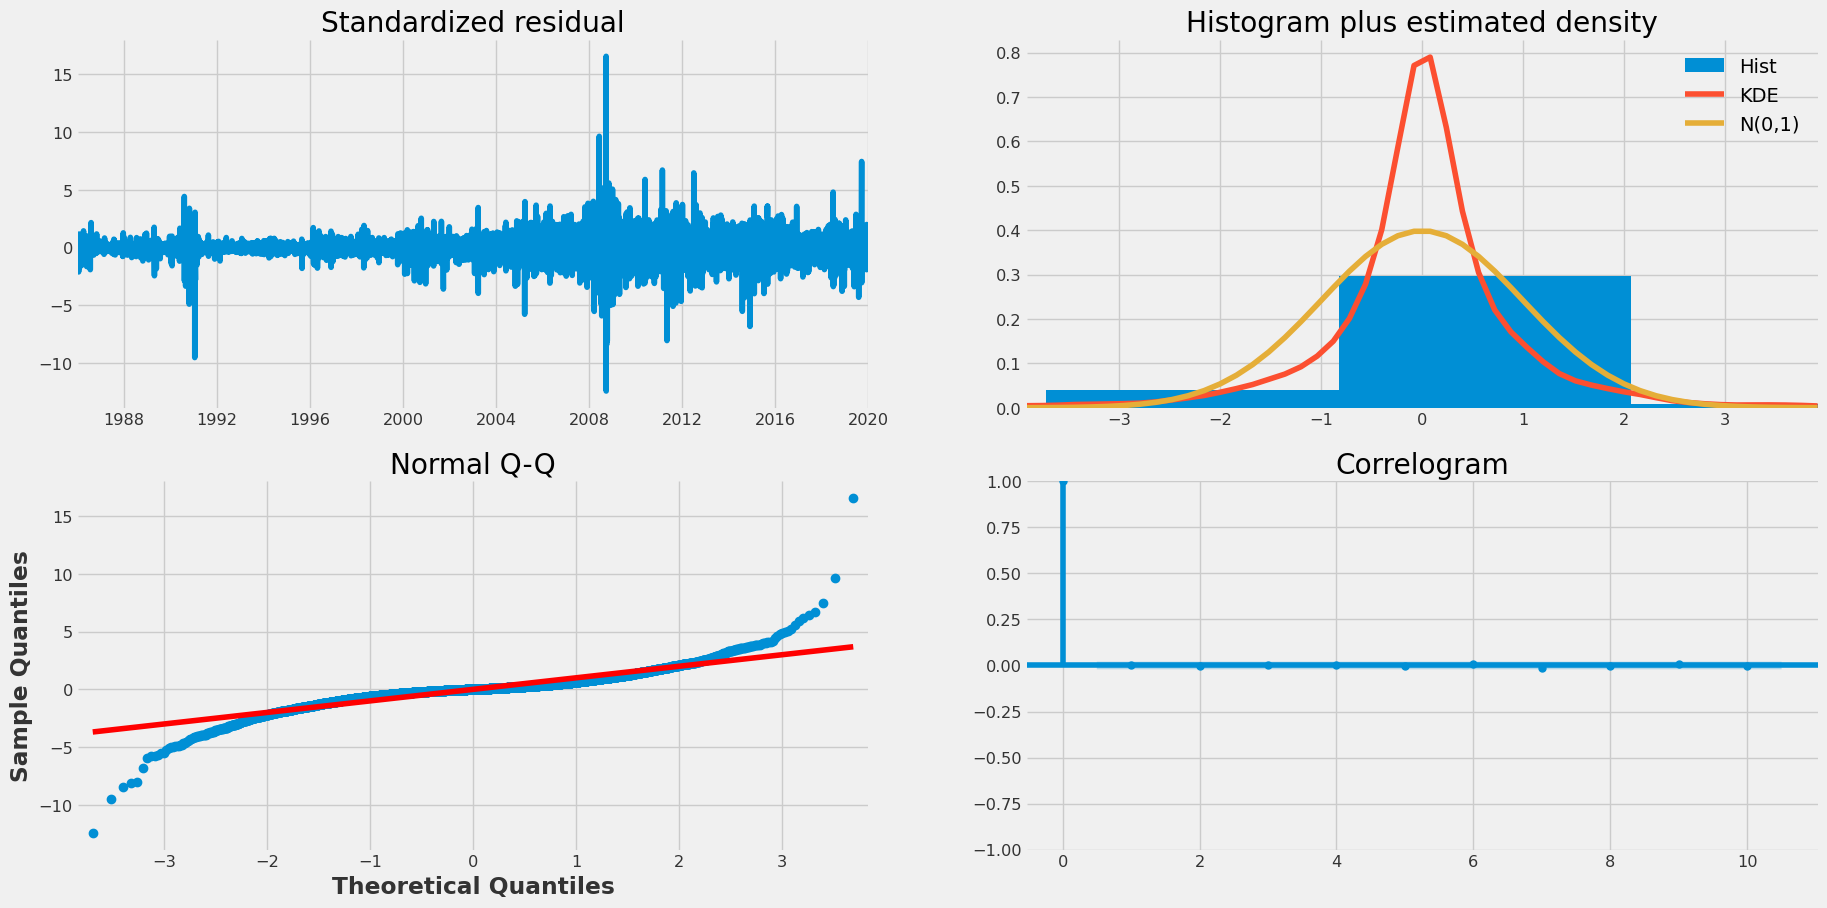

In [41]:
best_model.plot_diagnostics();

### Interpretation of the diagrams
#### Histogram
While a good part of the residuals have values at or around zero, one can not say conclusively from the histogram that the residuals are distributed normally. Indeed they display a heavy tail behaviour going all the way to negative three.

#### Normal quantile-quantile
The distribution follows roughly the red line (which corresponds to a normal distribution), however there are again strong outliers, indicating a heavy tail rather than purely Gaussian distribution of the residuals.

#### Correlogram (=ACF)
The correlogram indicates no significant autocorrelation of the residuals, which is a good indicator of their statistical independence.

# Forecasting 
Now that we have looked in some details at the price's behaviour, we may proceed to use different models to forecast its values. First we'll use the arima method from pmdarima which neatly provides for confidence intervals, and then we'll use the DARTS package, which unfortunately doesn't have confidence intervals but does have numerous different models to test out.

## PMDARIMA

In [42]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import time

In [43]:
def pmd_forecasts(value_series, start_date, end_date):
    model = best_model #The model that was selected by auto_arima
    forecasts = []
    confidence_intervals = []
    test_series = value_series[start_date:end_date] 
    
    for value in test_series:
        fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
        forecasts.append(fc[0])
        confidence_intervals.append(conf_int[0])
        model.update(value)
    
    return (pd.Series(forecasts, index=test_series.index),
            pd.DataFrame(confidence_intervals, index=test_series.index, columns=['lower', 'upper']))

In [44]:
def forecasts_rmse(actual_prices, forecasted_prices):
    '''
    Input: two pandas Dataframes
    Output: two floats (the rmse and smape)
    Returns the root mean squared error between the actual price and the forecasted price.
    '''
    start_date = forecasted_prices.index[0]
    return (mean_squared_error(actual_prices[start_date:], forecasted_prices), 
            smape(actual_prices[start_date:], forecasted_prices))

In [45]:
forecasts, conf_int = pmd_forecasts(WTI_filled, sep_date, WTI_filled.index[-1])

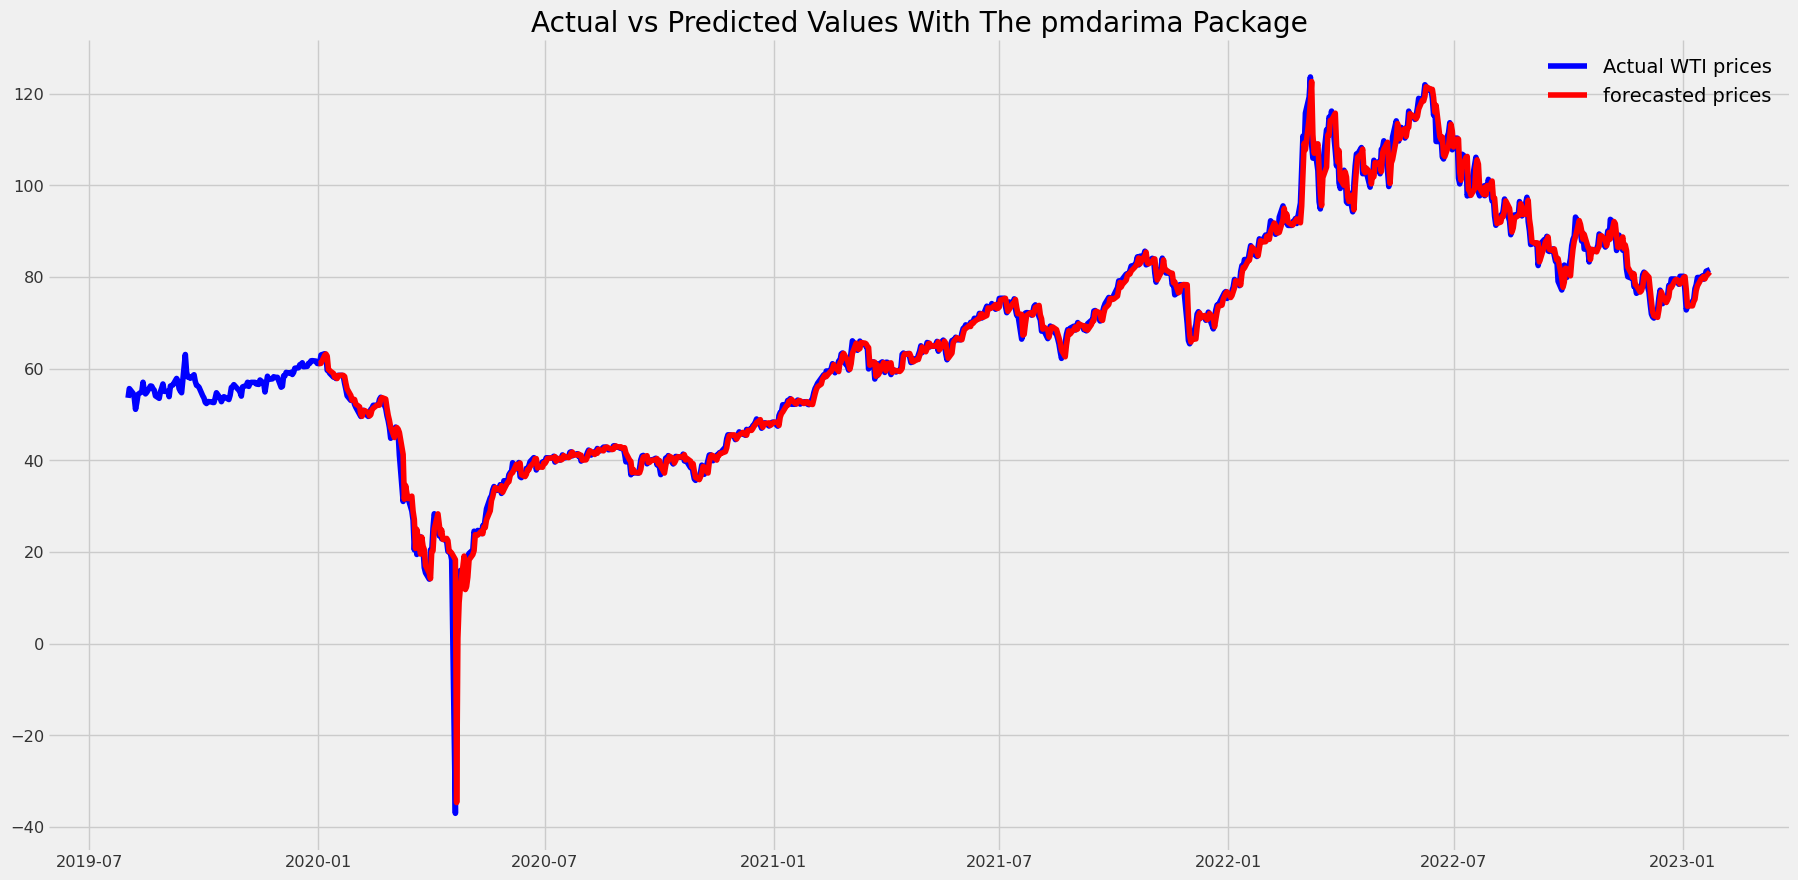

In [46]:
plt.plot(WTI_filled['2019-08-01':], color='blue', label='Actual WTI prices')
plt.plot(forecasts, color='red', label='forecasted prices')
plt.title('Actual vs Predicted Values With The pmdarima Package')
plt.legend();

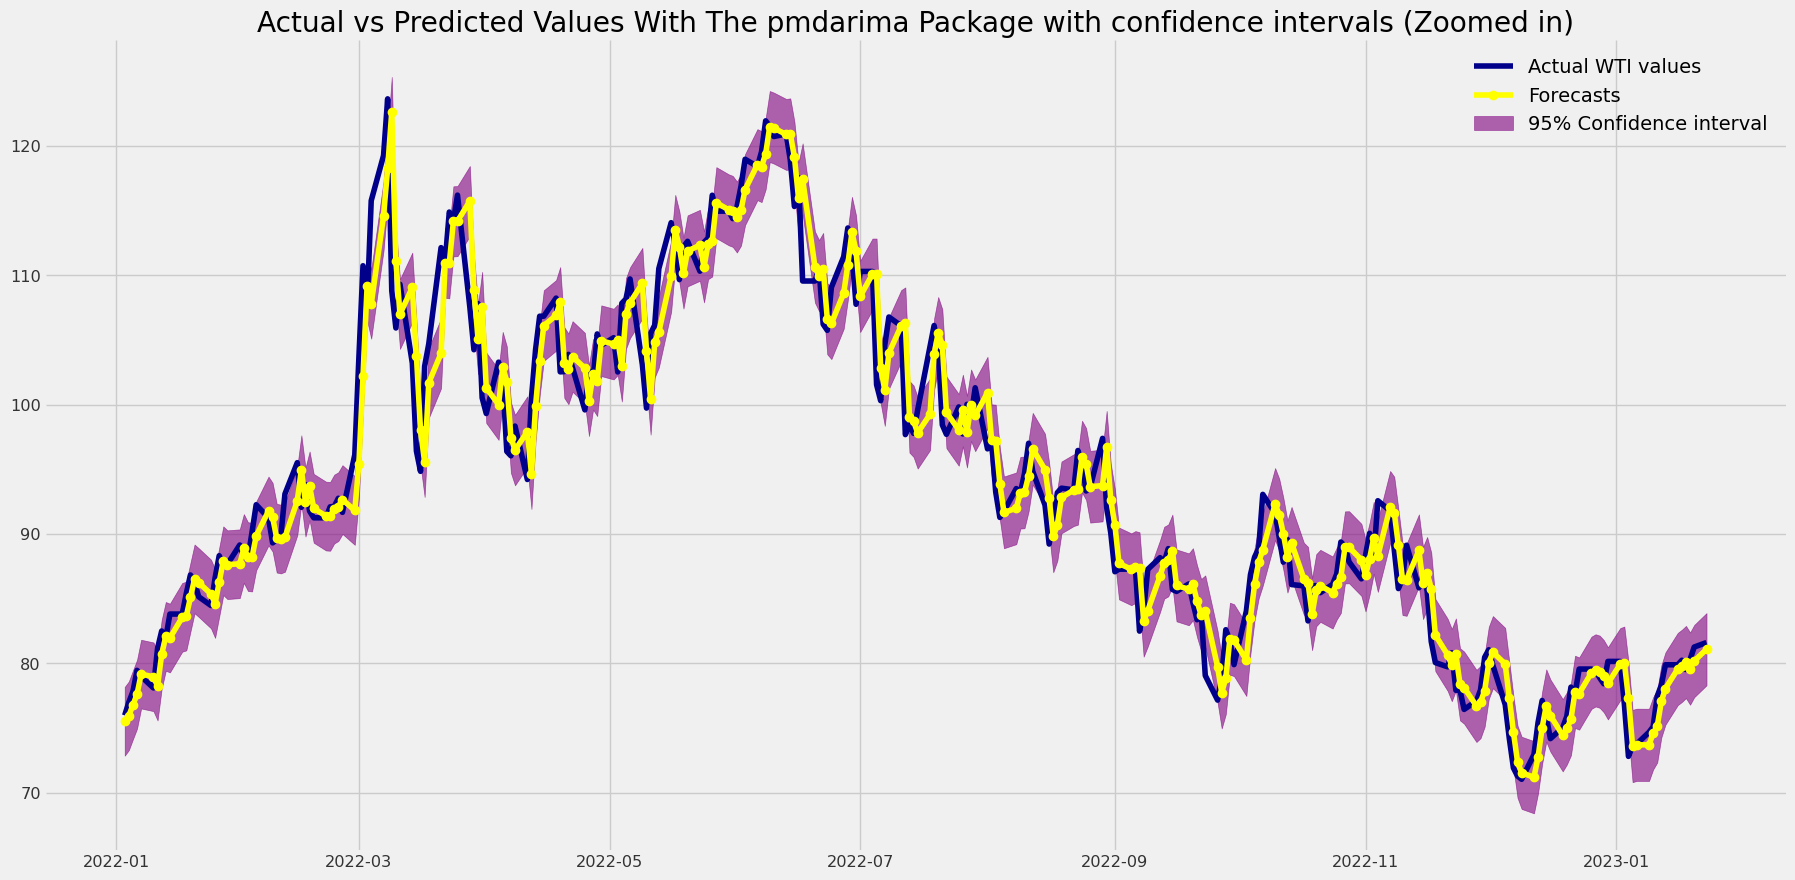

In [47]:
start = '2022-01-01'
plt.plot(WTI_filled[start:], color='darkblue', label='Actual WTI values')
plt.plot(forecasts[start:], color='yellow', marker='o', label='Forecasts')
plt.fill_between(WTI_filled[start:].index, conf_int[start:].lower, conf_int[start:].upper, 
                 color='purple', label='95% Confidence interval', alpha=.6)
plt.legend()
plt.title('Actual vs Predicted Values With The pmdarima Package with confidence intervals (Zoomed in)');

In [48]:
RMSE, SMAPE = forecasts_rmse(WTI_filled, forecasts)
print(f'With the method provided by the PMDARIMA package, the RMSE is of {RMSE:.2f} and the SMAPE to {SMAPE:.2f}%.')

With the method provided by the PMDARIMA package, the RMSE is of 11.04 and the SMAPE to 3.20%.


## DARTS
Now we'll look at the performance of different darts models

### Darts arima

In [49]:
from darts import TimeSeries
from darts.models.forecasting.arima import ARIMA as dartsarima

In [50]:
def forecasts(model, value_series, start_date, end_date):
    y_train = TimeSeries.from_series(value_series[:start_date])
    y_test = TimeSeries.from_series(value_series[start_date:end_date])
    model.fit(y_train)
    forecasts = model.historical_forecasts(y_test, start=.1, forecast_horizon=1)
    return forecasts.pd_series()

In [51]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = WTI_filled.index[-1]
model = dartsarima(p=5, d=1, q=0)
darts_arima_forecasts = forecasts(model, WTI_filled, start_date, end_date)

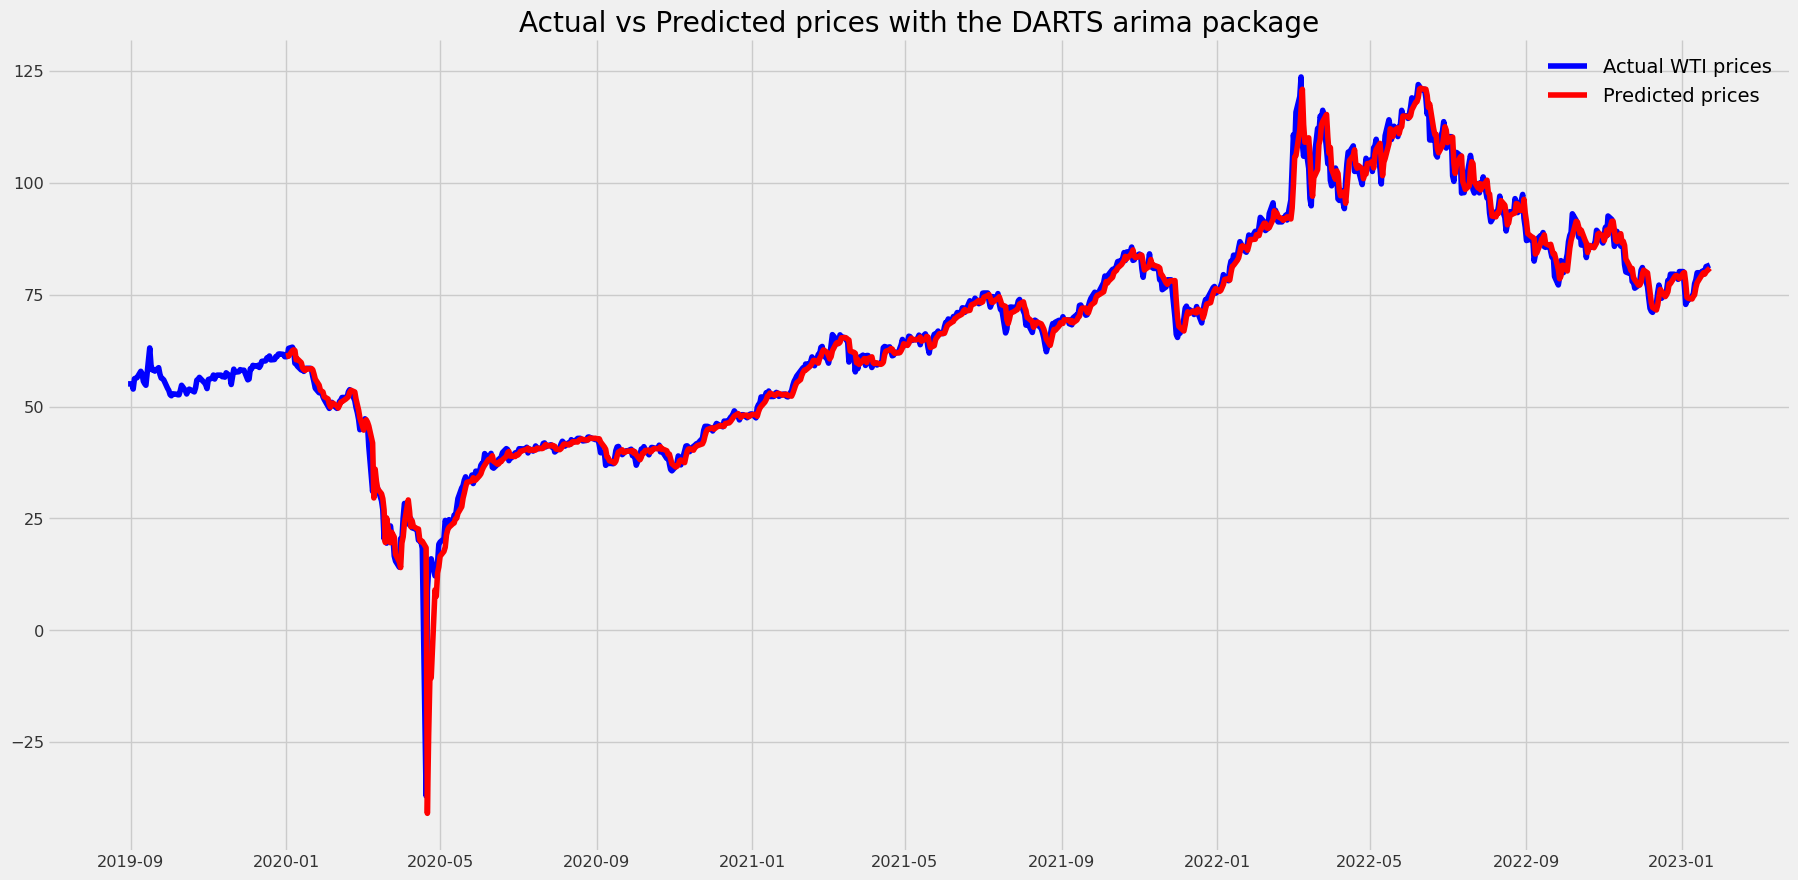

In [52]:
plt.plot(WTI_filled[start_date:end_date], label='Actual WTI prices', color='blue')
plt.plot(darts_arima_forecasts, color='red', label='Predicted prices' )
plt.title('Actual vs Predicted prices with the DARTS arima package')
plt.legend()

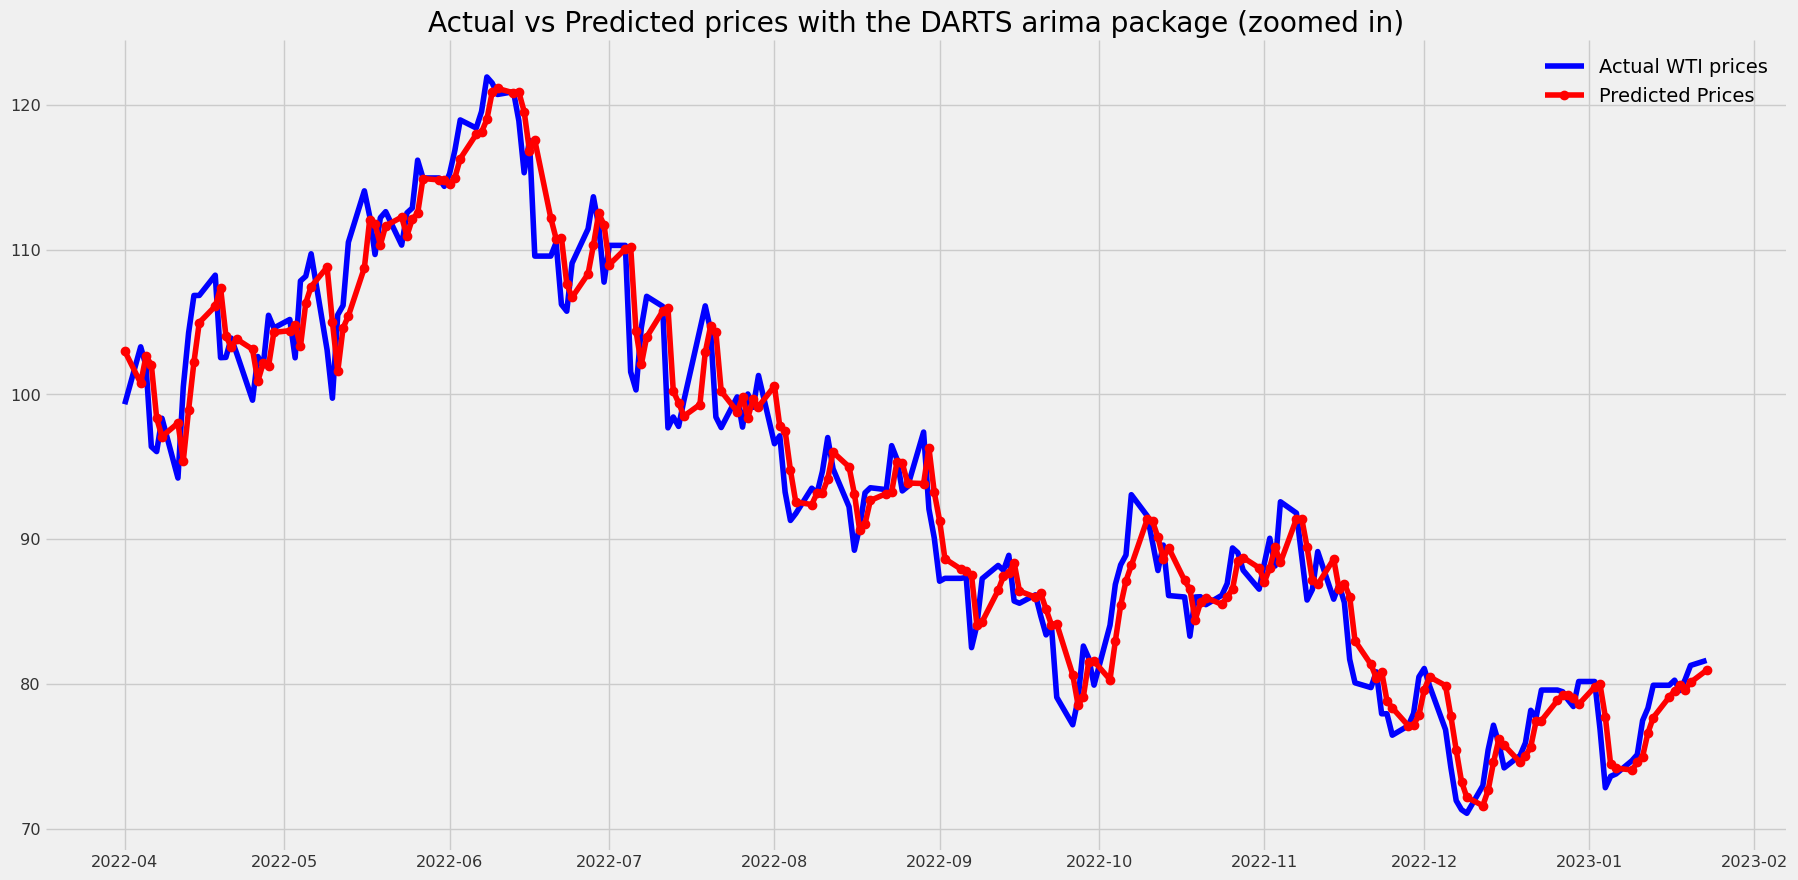

In [53]:
date_range = [str(x)[0:10] for x in pd.date_range('2022-04-01', end_date, freq='B')]
plt.plot(WTI_filled[date_range], color='blue', label='Actual WTI prices')
plt.plot(darts_arima_forecasts[date_range],color='red', marker='o', label='Predicted Prices')
plt.legend()
plt.title('Actual vs Predicted prices with the DARTS arima package (zoomed in)');

In [54]:
forecasts_rmse(WTI_filled, darts_arima_forecasts)

(15.6927869662908, 3.978486114035052)

### Other DARTS models
Let's now take a look at more modern machine learning methods and their predictive capabilities.

### Facebook's Prophet

In [55]:
from darts.models.forecasting.prophet_model import Prophet

In [ ]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = WTI_filled.index[-1]
model = Prophet()
prophet_forecasts = forecasts(model, WTI_filled, start_date, end_date)

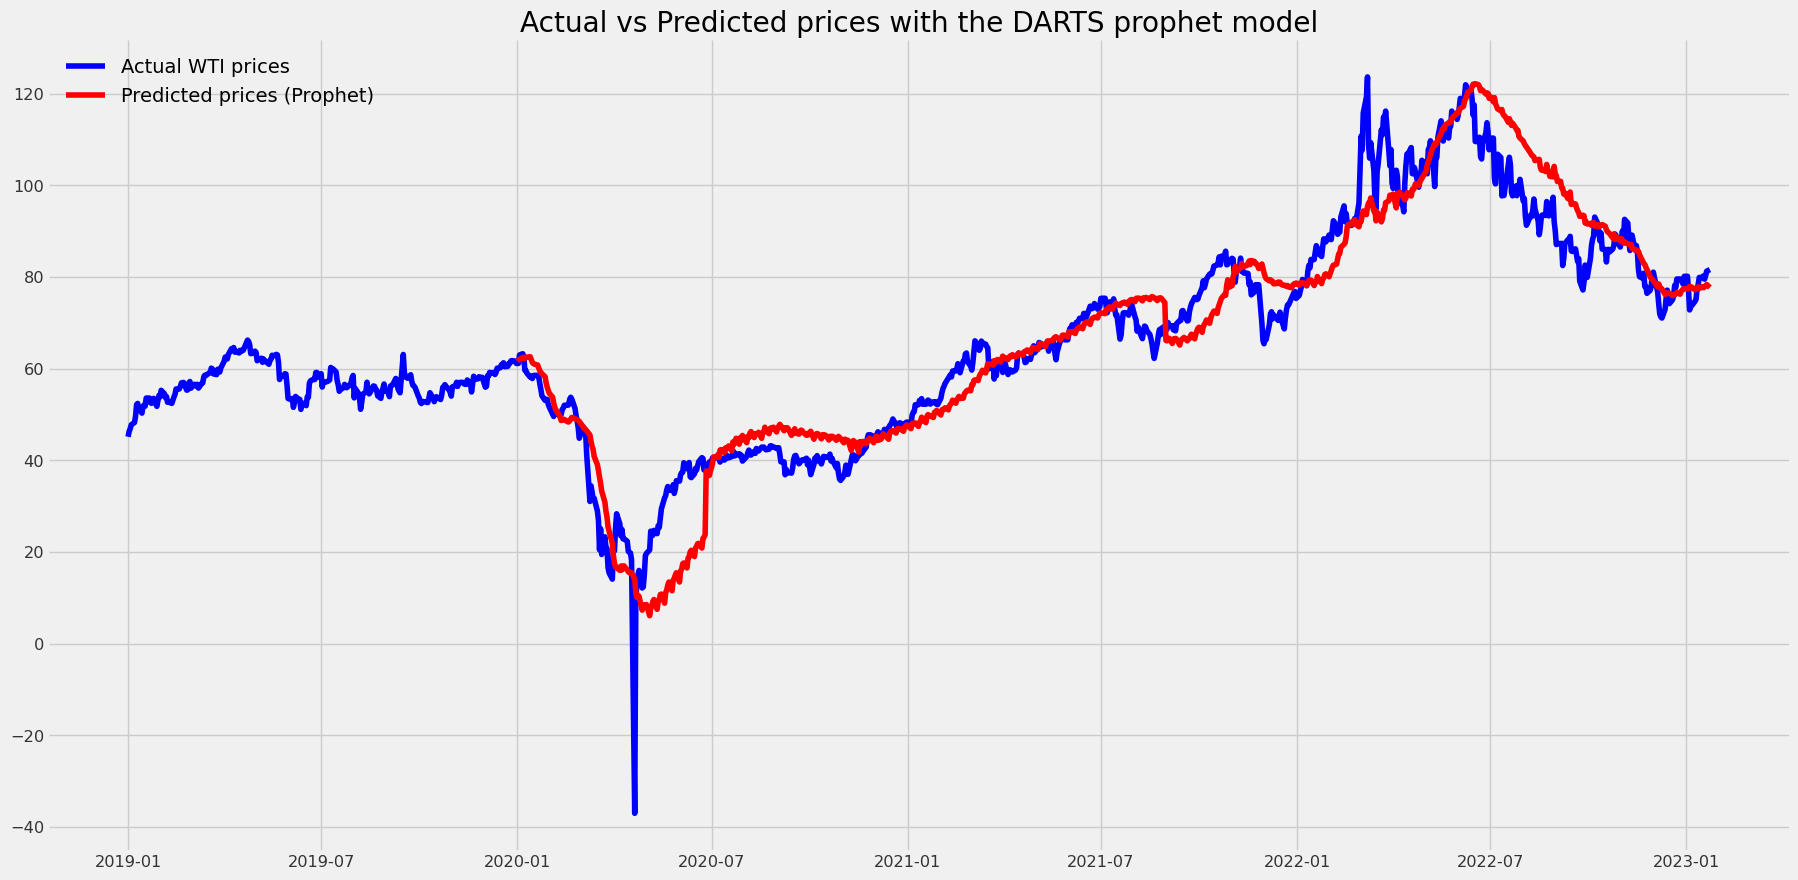

In [57]:
plt.plot(WTI_filled['2019-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(prophet_forecasts, color='red', label='Predicted prices (Prophet)' )
plt.title('Actual vs Predicted prices with the DARTS prophet model')
plt.legend()

In [58]:
forecasts_rmse(WTI_filled, prophet_forecasts)

(62.15925960614394, 12.005162086627337)

### Prophet's results
Despite the long compuation time needed to run the prophet model, one sees very clearly from the graph, and as is corroborated by the computation of RMSE and SMAPE (12% !), the model developed by facebook is not the promised prophet, only a very naughty boy.

However, if we look at the documentation on their GitHub page (https://github.com/facebook/prophet), the reason for the lack of strong predictive power becomes clear: the model was designed for data with strong seasonal patterns. 
This is clearly not the case here and the fact that the model performs poorly can be seen as an indirect proof of the lack of seasonality.

### Darts Exponential smoothing model

In [59]:
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing

In [60]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = WTI_filled.index[-1]
model = ExponentialSmoothing()
expsmooth_forecasts = forecasts(model, WTI_filled, start_date, end_date)

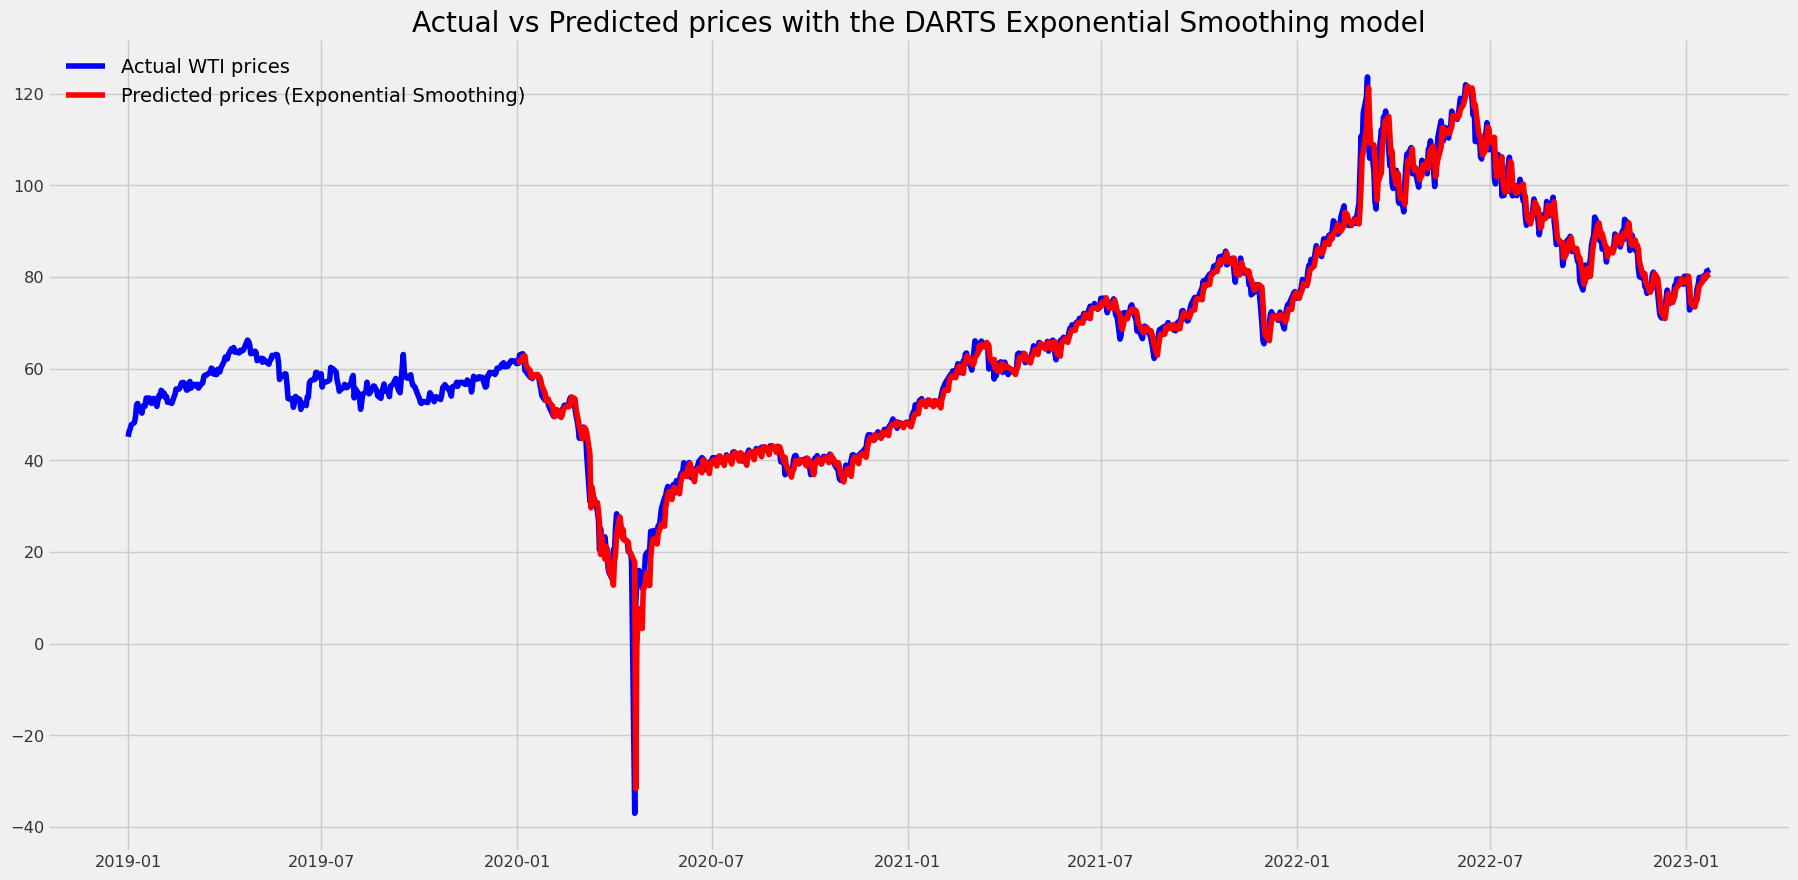

In [61]:
plt.plot(WTI_filled['2019-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(expsmooth_forecasts, color='red', label='Predicted prices (Exponential Smoothing)' )
plt.title('Actual vs Predicted prices with the DARTS Exponential Smoothing model')
plt.legend()

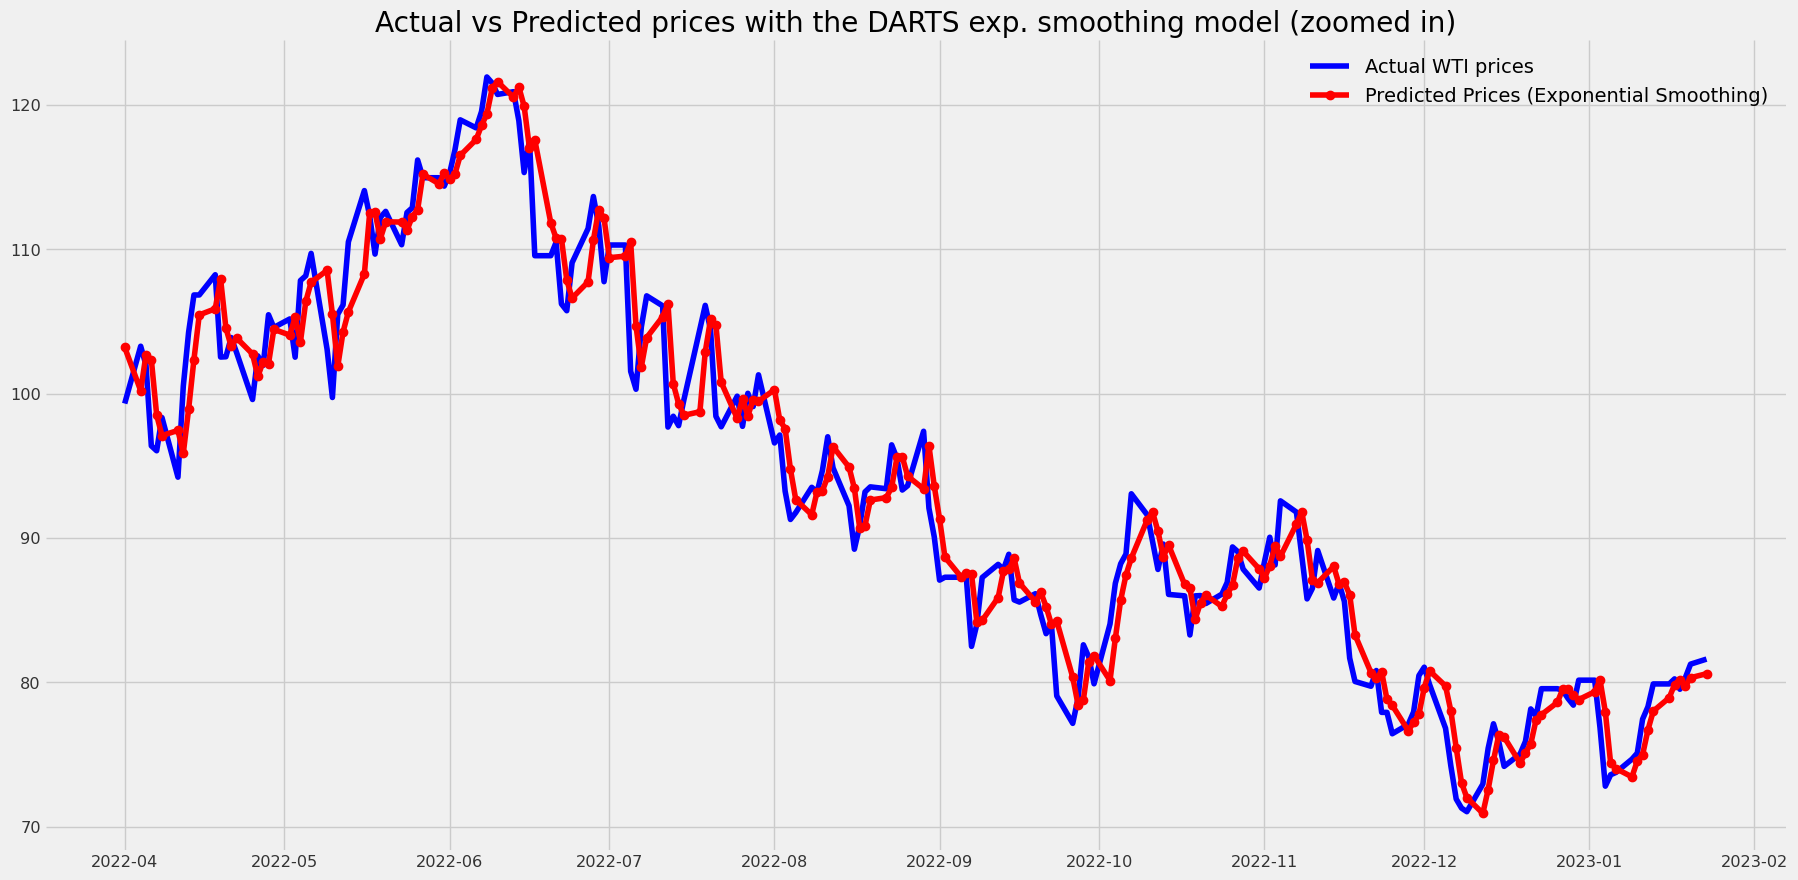

In [62]:
date_range = [str(x)[0:10] for x in pd.date_range('2022-04-01', end_date, freq='B')]
plt.plot(WTI_filled[date_range], color='blue', label='Actual WTI prices')
plt.plot(expsmooth_forecasts[date_range],color='red', marker='o', label='Predicted Prices (Exponential Smoothing)')
plt.legend()
plt.title('Actual vs Predicted prices with the DARTS exp. smoothing model (zoomed in)');

In [63]:
forecasts_rmse(WTI_filled, expsmooth_forecasts)

(11.937626111601308, 3.90105294375161)

#### Exponential Smoothing Results
The error is not too bad now, comparable to the one obtained by the ARIMA method from darts. Let's see if random forests can get a better error now.

### DARTS random forest

In [64]:
from darts.models.forecasting.random_forest import RandomForest

In [65]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = WTI_filled.index[-1]
model =  RandomForest(lags=5)
randomforest_forecasts = forecasts(model, WTI_filled, start_date, end_date)

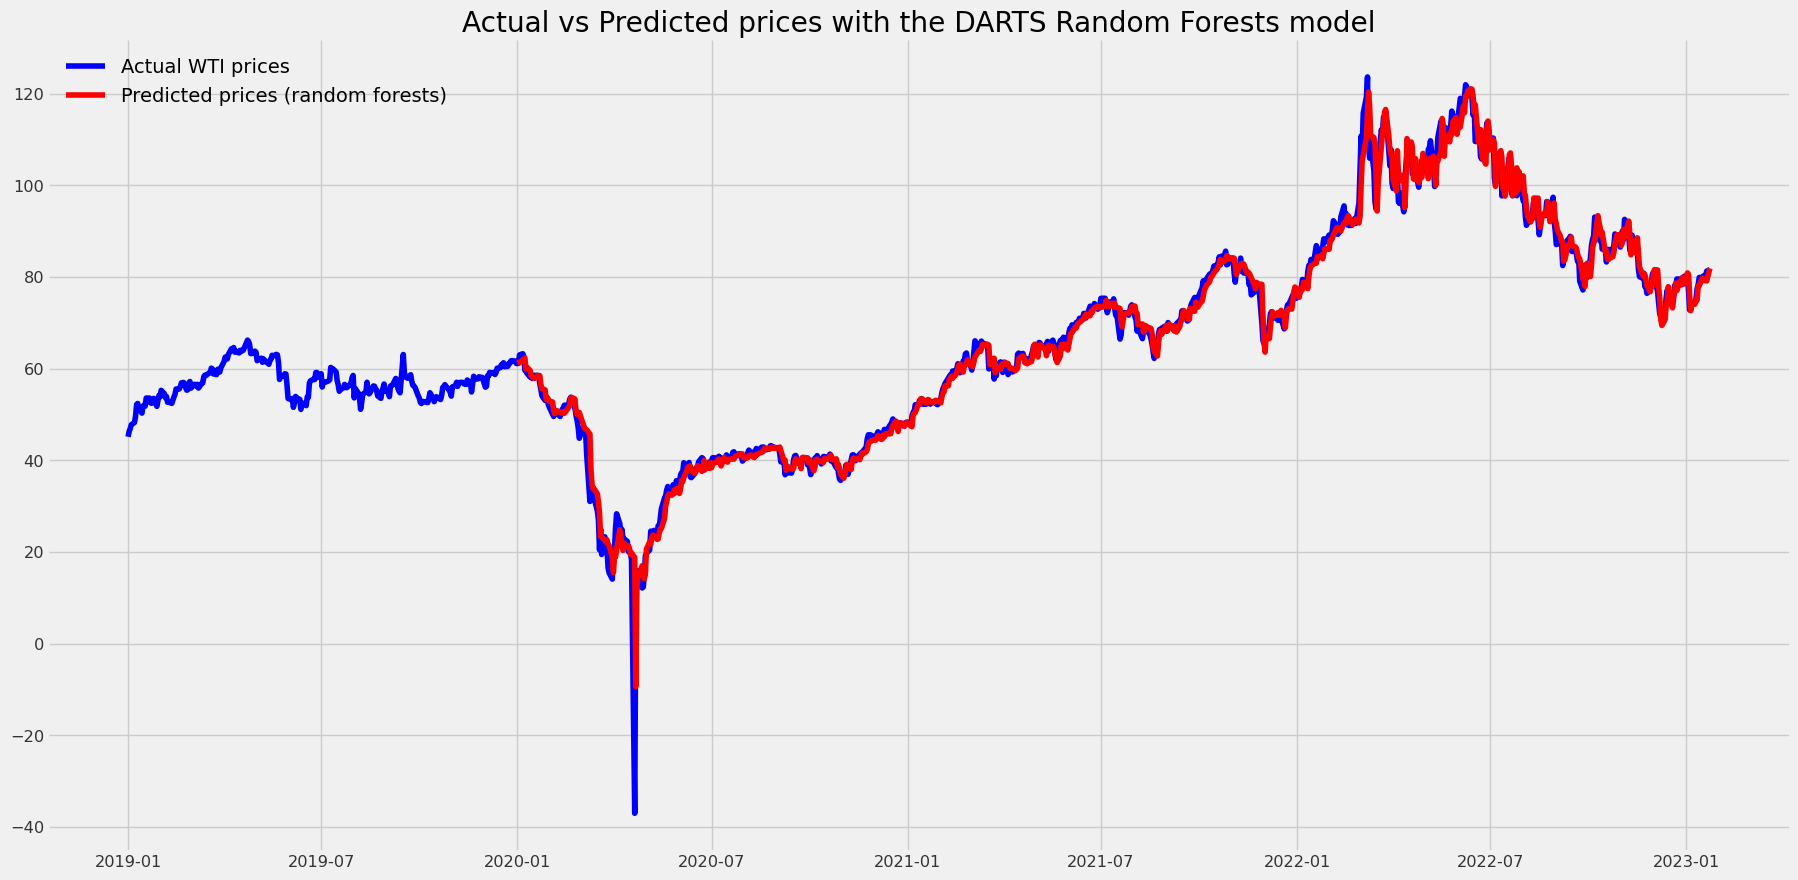

In [66]:
plt.plot(WTI_filled['2019-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(randomforest_forecasts, color='red', label='Predicted prices (random forests)' )
plt.title('Actual vs Predicted prices with the DARTS Random Forests model')
plt.legend()

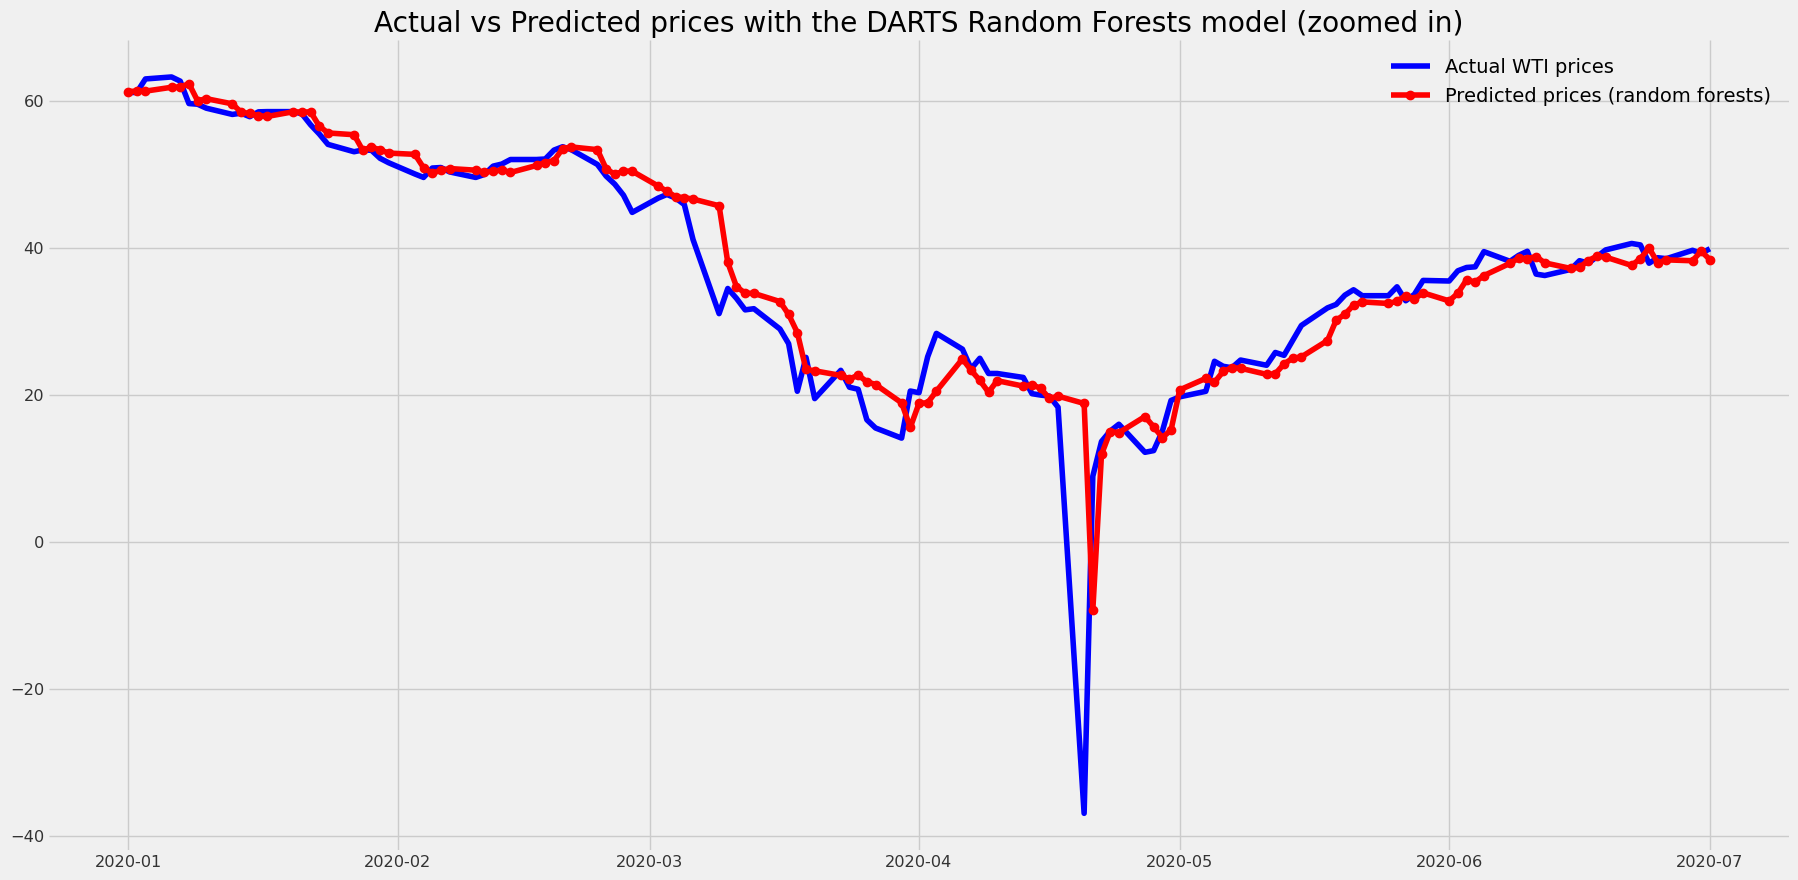

In [67]:
plt.plot(WTI_filled['2020-01-01':'2020-07-01'], label='Actual WTI prices', color='blue')
plt.plot(randomforest_forecasts[start_date:'2020-07-01'], color='red', marker='o', label='Predicted prices (random forests)' )
plt.title('Actual vs Predicted prices with the DARTS Random Forests model (zoomed in)')
plt.legend()

In [68]:
forecasts_rmse(WTI_filled, randomforest_forecasts)

(10.623831770037558, 3.4320596904870366)

From the above, we see that the random forests model produces a lower error than exponential smoothing and arima, but the extreme event from april 2020 is not predicted with great accuracy contrary to some previous models.

### Darts Linear Regression Model

In [69]:
from darts.models.forecasting.linear_regression_model import LinearRegressionModel

In [70]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = WTI_filled.index[-1]
model =  LinearRegressionModel(lags=5)
linear_forecasts = forecasts(model, WTI_filled, start_date, end_date)

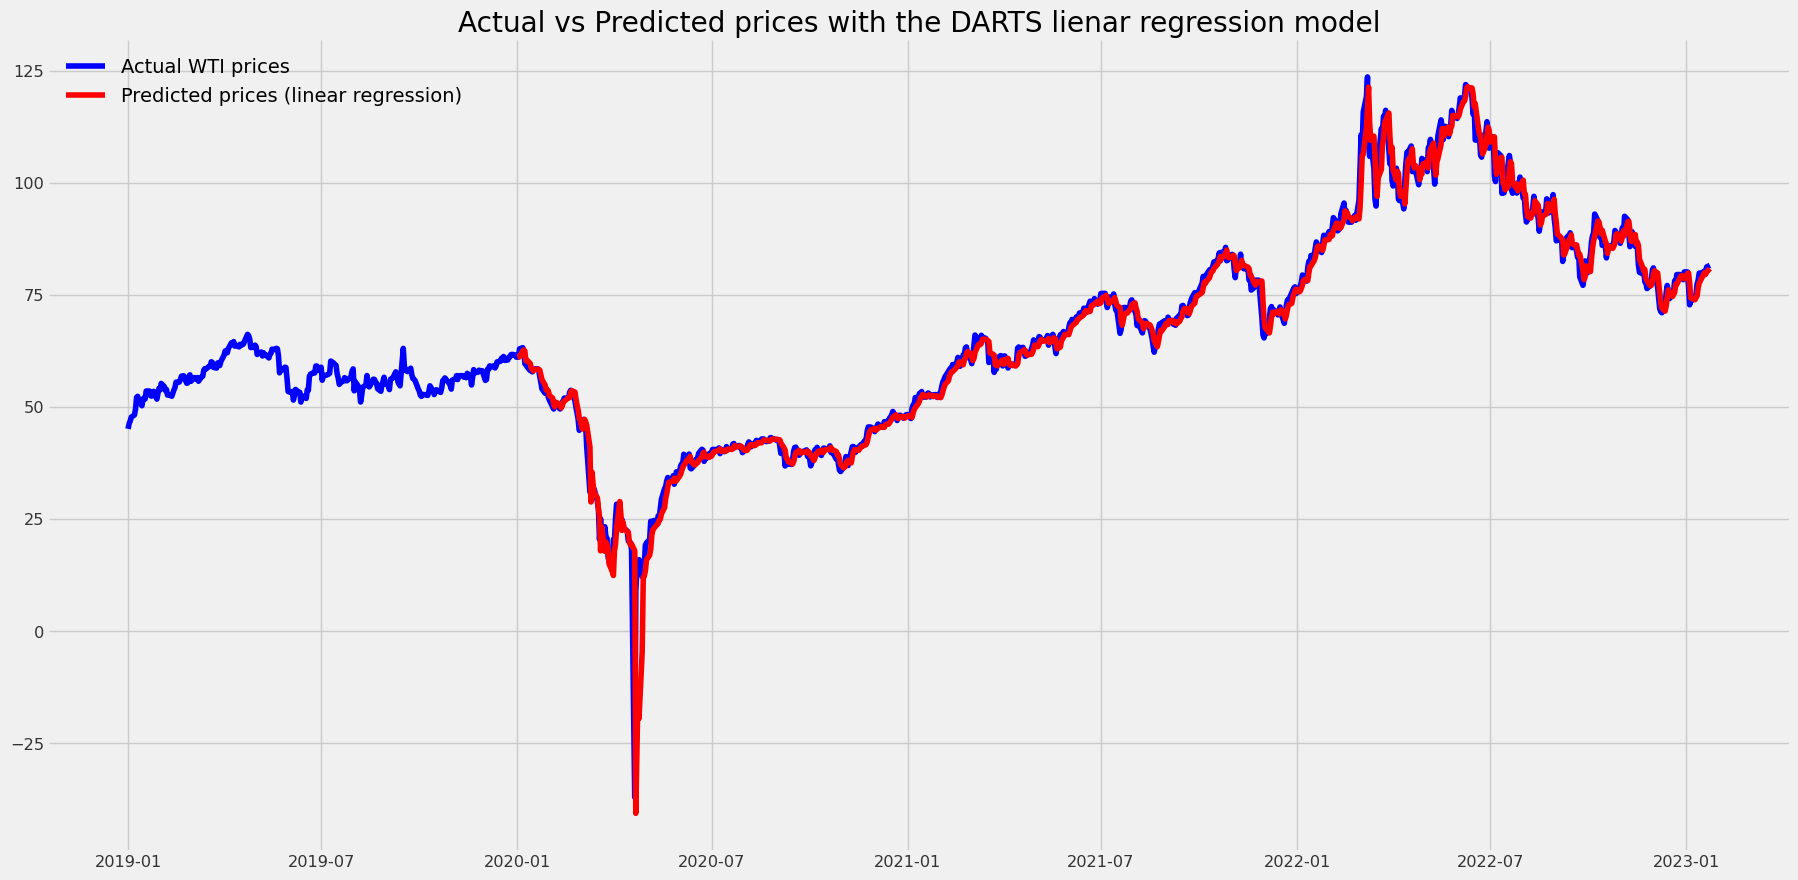

In [71]:
plt.plot(WTI_filled['2019-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(linear_forecasts, color='red', label='Predicted prices (linear regression)' )
plt.title('Actual vs Predicted prices with the DARTS lienar regression model')
plt.legend()

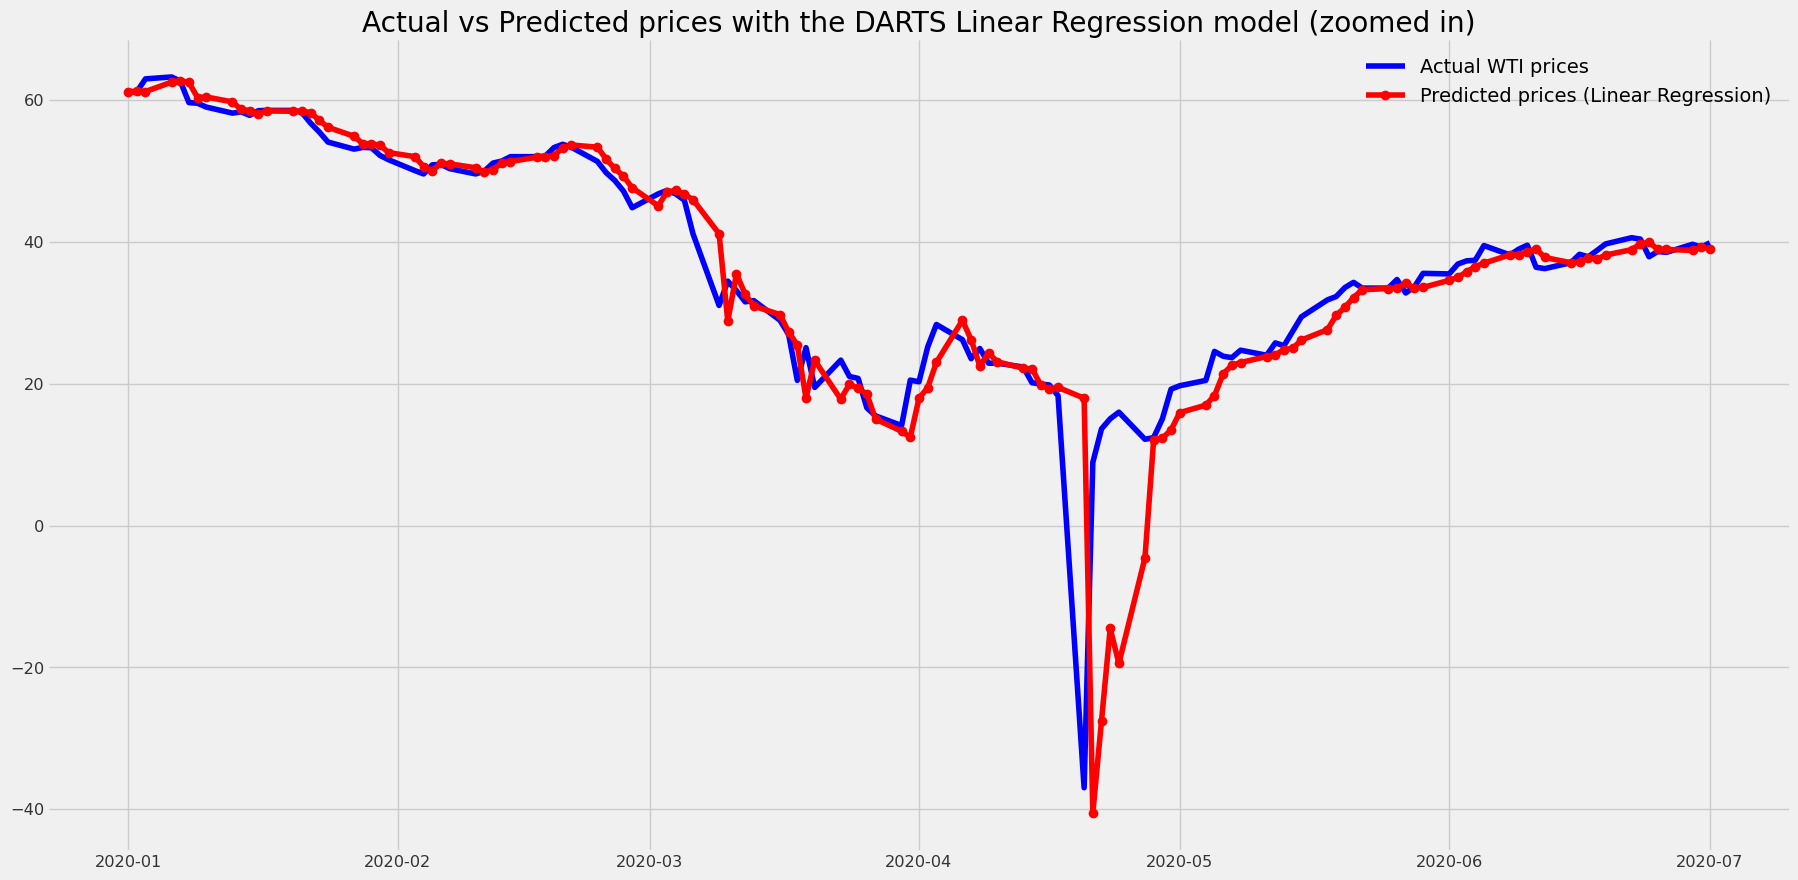

In [72]:
plt.plot(WTI_filled['2020-01-01':'2020-07-01'], label='Actual WTI prices', color='blue')
plt.plot(linear_forecasts[start_date:'2020-07-01'], color='red', marker='o', label='Predicted prices (Linear Regression)' )
plt.title('Actual vs Predicted prices with the DARTS Linear Regression model (zoomed in)')
plt.legend()

In [73]:
forecasts_rmse(WTI_filled, linear_forecasts)

(17.409167455250056, 4.197693169129162)

# Summary
We have successfully analysed different components of the WTI prices from 1986 to today, and were able to produce accurate forecasts with the help of the ARIMA, the exponential smoothing function, as well as the linear regression model. The ARIMA method from the pmdarima package produced the best results so far, with a SMAPE of $3.21\%$